# Afriat

In [1]:
ood_seed = 8

In [2]:
num_ood = 1  # not functioning

In [3]:
obs_key = "zone"

In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [8]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('2.0', 'Periportal', 'Uninfected')

Removed datapoint: 1330


In [9]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [10]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 3rq5xlgs
Name: holographic-nerf-herder-408
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/3rq5xlgs
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_104507-3rq5xlgs/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4470,9709
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1114,2430
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:26:00,  8.62s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:26:00,  8.62s/it, v_num=gs_1, total_loss_train=3.71e+3, kl_local_train=43]

Epoch 2/600:   0%|          | 1/600 [00:08<1:26:00,  8.62s/it, v_num=gs_1, total_loss_train=3.71e+3, kl_local_train=43]

Epoch 2/600:   0%|          | 2/600 [00:14<1:10:37,  7.09s/it, v_num=gs_1, total_loss_train=3.71e+3, kl_local_train=43]

Epoch 2/600:   0%|          | 2/600 [00:14<1:10:37,  7.09s/it, v_num=gs_1, total_loss_train=3.2e+3, kl_local_train=67.3]

Epoch 3/600:   0%|          | 2/600 [00:14<1:10:37,  7.09s/it, v_num=gs_1, total_loss_train=3.2e+3, kl_local_train=67.3]

Epoch 3/600:   0%|          | 3/600 [00:20<1:05:29,  6.58s/it, v_num=gs_1, total_loss_train=3.2e+3, kl_local_train=67.3]

Epoch 3/600:   0%|          | 3/600 [00:20<1:05:29,  6.58s/it, v_num=gs_1, total_loss_train=3.19e+3, kl_local_train=70.7]

Epoch 4/600:   0%|          | 3/600 [00:20<1:05:29,  6.58s/it, v_num=gs_1, total_loss_train=3.19e+3, kl_local_train=70.7]

Epoch 4/600:   1%|          | 4/600 [00:26<1:03:25,  6.38s/it, v_num=gs_1, total_loss_train=3.19e+3, kl_local_train=70.7]

Epoch 4/600:   1%|          | 4/600 [00:26<1:03:25,  6.38s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=70.4]

Epoch 5/600:   1%|          | 4/600 [00:26<1:03:25,  6.38s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=70.4]

Epoch 5/600:   1%|          | 5/600 [00:32<1:02:03,  6.26s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=70.4]

Epoch 5/600:   1%|          | 5/600 [00:32<1:02:03,  6.26s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=67.6]

Epoch 6/600:   1%|          | 5/600 [00:32<1:02:03,  6.26s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=67.6]

Epoch 6/600:   1%|          | 6/600 [00:38<1:01:12,  6.18s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=67.6]

Epoch 6/600:   1%|          | 6/600 [00:38<1:01:12,  6.18s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=62.5]

Epoch 7/600:   1%|          | 6/600 [00:38<1:01:12,  6.18s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=62.5]

Epoch 7/600:   1%|          | 7/600 [00:44<1:01:00,  6.17s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=62.5]

Epoch 7/600:   1%|          | 7/600 [00:44<1:01:00,  6.17s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=55.4]

Epoch 8/600:   1%|          | 7/600 [00:44<1:01:00,  6.17s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=55.4]

Epoch 8/600:   1%|▏         | 8/600 [00:51<1:00:43,  6.15s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=55.4]

Epoch 8/600:   1%|▏         | 8/600 [00:51<1:00:43,  6.15s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=44.1]

Epoch 9/600:   1%|▏         | 8/600 [00:51<1:00:43,  6.15s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=44.1]

Epoch 9/600:   2%|▏         | 9/600 [00:57<1:00:44,  6.17s/it, v_num=gs_1, total_loss_train=3.18e+3, kl_local_train=44.1]

Epoch 9/600:   2%|▏         | 9/600 [00:57<1:00:44,  6.17s/it, v_num=gs_1, total_loss_train=3.17e+3, kl_local_train=39]  

Epoch 10/600:   2%|▏         | 9/600 [00:57<1:00:44,  6.17s/it, v_num=gs_1, total_loss_train=3.17e+3, kl_local_train=39]

Epoch 10/600:   2%|▏         | 10/600 [01:03<1:00:35,  6.16s/it, v_num=gs_1, total_loss_train=3.17e+3, kl_local_train=39]

Epoch 10/600:   2%|▏         | 10/600 [01:03<1:00:35,  6.16s/it, v_num=gs_1, total_loss_train=3.16e+3, kl_local_train=67.7]

Epoch 11/600:   2%|▏         | 10/600 [01:03<1:00:35,  6.16s/it, v_num=gs_1, total_loss_train=3.16e+3, kl_local_train=67.7]

Epoch 11/600:   2%|▏         | 11/600 [01:09<1:00:25,  6.15s/it, v_num=gs_1, total_loss_train=3.16e+3, kl_local_train=67.7]

Epoch 11/600:   2%|▏         | 11/600 [01:09<1:00:25,  6.15s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=109] 

Epoch 12/600:   2%|▏         | 11/600 [01:09<1:00:25,  6.15s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 12/600:   2%|▏         | 12/600 [01:15<1:00:16,  6.15s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=109]

Epoch 12/600:   2%|▏         | 12/600 [01:15<1:00:16,  6.15s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=155]

Epoch 13/600:   2%|▏         | 12/600 [01:15<1:00:16,  6.15s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=155]

Epoch 13/600:   2%|▏         | 13/600 [01:21<59:59,  6.13s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=155]  

Epoch 13/600:   2%|▏         | 13/600 [01:21<59:59,  6.13s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=187]

Epoch 14/600:   2%|▏         | 13/600 [01:21<59:59,  6.13s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=187]

Epoch 14/600:   2%|▏         | 14/600 [01:27<59:52,  6.13s/it, v_num=gs_1, total_loss_train=3.15e+3, kl_local_train=187]

Epoch 14/600:   2%|▏         | 14/600 [01:27<59:52,  6.13s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=229]

Epoch 15/600:   2%|▏         | 14/600 [01:27<59:52,  6.13s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=229]

Epoch 15/600:   2%|▎         | 15/600 [01:33<59:41,  6.12s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=229]

Epoch 15/600:   2%|▎         | 15/600 [01:33<59:41,  6.12s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=266]

Epoch 16/600:   2%|▎         | 15/600 [01:33<59:41,  6.12s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=266]

Epoch 16/600:   3%|▎         | 16/600 [01:40<59:35,  6.12s/it, v_num=gs_1, total_loss_train=3.14e+3, kl_local_train=266]

Epoch 16/600:   3%|▎         | 16/600 [01:40<59:35,  6.12s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=293]

Epoch 17/600:   3%|▎         | 16/600 [01:40<59:35,  6.12s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=293]

Epoch 17/600:   3%|▎         | 17/600 [01:46<59:34,  6.13s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=293]

Epoch 17/600:   3%|▎         | 17/600 [01:46<59:34,  6.13s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=300]

Epoch 18/600:   3%|▎         | 17/600 [01:46<59:34,  6.13s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=300]

Epoch 18/600:   3%|▎         | 18/600 [01:52<59:34,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=300]

Epoch 18/600:   3%|▎         | 18/600 [01:52<59:34,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=302]

Epoch 19/600:   3%|▎         | 18/600 [01:52<59:34,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=302]

Epoch 19/600:   3%|▎         | 19/600 [01:58<59:29,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=302]

Epoch 19/600:   3%|▎         | 19/600 [01:58<59:29,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=304]

Epoch 20/600:   3%|▎         | 19/600 [01:58<59:29,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=304]

Epoch 20/600:   3%|▎         | 20/600 [02:04<59:21,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=304]

Epoch 20/600:   3%|▎         | 20/600 [02:04<59:21,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=307]

Epoch 21/600:   3%|▎         | 20/600 [02:04<59:21,  6.14s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=307]

Epoch 21/600:   4%|▎         | 21/600 [02:10<57:54,  6.00s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=307]

Epoch 21/600:   4%|▎         | 21/600 [02:10<57:54,  6.00s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=310]

Epoch 22/600:   4%|▎         | 21/600 [02:10<57:54,  6.00s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=310]

Epoch 22/600:   4%|▎         | 22/600 [02:16<56:43,  5.89s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=310]

Epoch 22/600:   4%|▎         | 22/600 [02:16<56:43,  5.89s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=319]

Epoch 23/600:   4%|▎         | 22/600 [02:16<56:43,  5.89s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=319]

Epoch 23/600:   4%|▍         | 23/600 [02:21<56:03,  5.83s/it, v_num=gs_1, total_loss_train=3.13e+3, kl_local_train=319]

Epoch 23/600:   4%|▍         | 23/600 [02:21<56:03,  5.83s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=299]

Epoch 24/600:   4%|▍         | 23/600 [02:21<56:03,  5.83s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=299]

Epoch 24/600:   4%|▍         | 24/600 [02:27<55:22,  5.77s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=299]

Epoch 24/600:   4%|▍         | 24/600 [02:27<55:22,  5.77s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=274]

Epoch 25/600:   4%|▍         | 24/600 [02:27<55:22,  5.77s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=274]

Epoch 25/600:   4%|▍         | 25/600 [02:32<54:56,  5.73s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=274]

Epoch 25/600:   4%|▍         | 25/600 [02:32<54:56,  5.73s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=275]

Epoch 26/600:   4%|▍         | 25/600 [02:32<54:56,  5.73s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=275]

Epoch 26/600:   4%|▍         | 26/600 [02:38<54:33,  5.70s/it, v_num=gs_1, total_loss_train=3.12e+3, kl_local_train=275]

Epoch 26/600:   4%|▍         | 26/600 [02:38<54:33,  5.70s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=248]

Epoch 27/600:   4%|▍         | 26/600 [02:38<54:33,  5.70s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=248]

Epoch 27/600:   4%|▍         | 27/600 [02:44<54:13,  5.68s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=248]

Epoch 27/600:   4%|▍         | 27/600 [02:44<54:13,  5.68s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=212]

Epoch 28/600:   4%|▍         | 27/600 [02:44<54:13,  5.68s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=212]

Epoch 28/600:   5%|▍         | 28/600 [02:49<54:05,  5.67s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=212]

Epoch 28/600:   5%|▍         | 28/600 [02:49<54:05,  5.67s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=192]

Epoch 29/600:   5%|▍         | 28/600 [02:49<54:05,  5.67s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=192]

Epoch 29/600:   5%|▍         | 29/600 [02:55<53:48,  5.65s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=192]

Epoch 29/600:   5%|▍         | 29/600 [02:55<53:48,  5.65s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=167]

Epoch 30/600:   5%|▍         | 29/600 [02:55<53:48,  5.65s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=167]

Epoch 30/600:   5%|▌         | 30/600 [03:01<53:43,  5.66s/it, v_num=gs_1, total_loss_train=3.11e+3, kl_local_train=167]

Epoch 30/600:   5%|▌         | 30/600 [03:01<53:43,  5.66s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=146] 

Epoch 31/600:   5%|▌         | 30/600 [03:01<53:43,  5.66s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=146]

Epoch 31/600:   5%|▌         | 31/600 [03:06<53:20,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=146]

Epoch 31/600:   5%|▌         | 31/600 [03:06<53:20,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=129]

Epoch 32/600:   5%|▌         | 31/600 [03:06<53:20,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=129]

Epoch 32/600:   5%|▌         | 32/600 [03:12<53:12,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=129]

Epoch 32/600:   5%|▌         | 32/600 [03:12<53:12,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=120]

Epoch 33/600:   5%|▌         | 32/600 [03:12<53:12,  5.62s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=120]

Epoch 33/600:   6%|▌         | 33/600 [03:17<53:01,  5.61s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=120]

Epoch 33/600:   6%|▌         | 33/600 [03:17<53:01,  5.61s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=113]

Epoch 34/600:   6%|▌         | 33/600 [03:17<53:01,  5.61s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=113]

Epoch 34/600:   6%|▌         | 34/600 [03:23<52:41,  5.59s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=113]

Epoch 34/600:   6%|▌         | 34/600 [03:23<52:41,  5.59s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 35/600:   6%|▌         | 34/600 [03:23<52:41,  5.59s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 35/600:   6%|▌         | 35/600 [03:28<52:30,  5.58s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 35/600:   6%|▌         | 35/600 [03:28<52:30,  5.58s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 36/600:   6%|▌         | 35/600 [03:28<52:30,  5.58s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 36/600:   6%|▌         | 36/600 [03:34<52:21,  5.57s/it, v_num=gs_1, total_loss_train=3.1e+3, kl_local_train=107]

Epoch 36/600:   6%|▌         | 36/600 [03:34<52:21,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 37/600:   6%|▌         | 36/600 [03:34<52:21,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 37/600:   6%|▌         | 37/600 [03:40<52:15,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=101]

Epoch 37/600:   6%|▌         | 37/600 [03:40<52:15,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 38/600:   6%|▌         | 37/600 [03:40<52:15,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 38/600:   6%|▋         | 38/600 [03:45<52:08,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=98.4]

Epoch 38/600:   6%|▋         | 38/600 [03:45<52:08,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=99.4]

Epoch 39/600:   6%|▋         | 38/600 [03:45<52:08,  5.57s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=99.4]

Epoch 39/600:   6%|▋         | 39/600 [03:51<53:16,  5.70s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=99.4]

Epoch 39/600:   6%|▋         | 39/600 [03:51<53:16,  5.70s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 40/600:   6%|▋         | 39/600 [03:51<53:16,  5.70s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 40/600:   7%|▋         | 40/600 [03:57<54:05,  5.79s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.8]

Epoch 40/600:   7%|▋         | 40/600 [03:57<54:05,  5.79s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 41/600:   7%|▋         | 40/600 [03:57<54:05,  5.79s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 41/600:   7%|▋         | 41/600 [04:03<54:43,  5.87s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=95.3]

Epoch 41/600:   7%|▋         | 41/600 [04:03<54:43,  5.87s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.2]

Epoch 42/600:   7%|▋         | 41/600 [04:03<54:43,  5.87s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.2]

Epoch 42/600:   7%|▋         | 42/600 [04:09<55:06,  5.93s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.2]

Epoch 42/600:   7%|▋         | 42/600 [04:09<55:06,  5.93s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 43/600:   7%|▋         | 42/600 [04:09<55:06,  5.93s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 43/600:   7%|▋         | 43/600 [04:15<55:16,  5.96s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=93.3]

Epoch 43/600:   7%|▋         | 43/600 [04:15<55:16,  5.96s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 44/600:   7%|▋         | 43/600 [04:15<55:16,  5.96s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 44/600:   7%|▋         | 44/600 [04:21<55:20,  5.97s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 44/600:   7%|▋         | 44/600 [04:21<55:20,  5.97s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 45/600:   7%|▋         | 44/600 [04:21<55:20,  5.97s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 45/600:   8%|▊         | 45/600 [04:27<55:30,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 45/600:   8%|▊         | 45/600 [04:27<55:30,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 46/600:   8%|▊         | 45/600 [04:27<55:30,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 46/600:   8%|▊         | 46/600 [04:33<55:26,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 46/600:   8%|▊         | 46/600 [04:33<55:26,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 47/600:   8%|▊         | 46/600 [04:33<55:26,  6.00s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 47/600:   8%|▊         | 47/600 [04:40<55:36,  6.03s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 47/600:   8%|▊         | 47/600 [04:40<55:36,  6.03s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 48/600:   8%|▊         | 47/600 [04:40<55:36,  6.03s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 48/600:   8%|▊         | 48/600 [04:46<55:46,  6.06s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 48/600:   8%|▊         | 48/600 [04:46<55:46,  6.06s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.8]

Epoch 49/600:   8%|▊         | 48/600 [04:46<55:46,  6.06s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.8]

Epoch 49/600:   8%|▊         | 49/600 [04:52<55:43,  6.07s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=90.8]

Epoch 49/600:   8%|▊         | 49/600 [04:52<55:43,  6.07s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 50/600:   8%|▊         | 49/600 [04:52<55:43,  6.07s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 50/600:   8%|▊         | 50/600 [04:58<55:44,  6.08s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 50/600:   8%|▊         | 50/600 [04:58<55:44,  6.08s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 51/600:   8%|▊         | 50/600 [04:58<55:44,  6.08s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 51/600:   8%|▊         | 51/600 [05:04<55:38,  6.08s/it, v_num=gs_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 51/600:   8%|▊         | 51/600 [05:04<55:38,  6.08s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 52/600:   8%|▊         | 51/600 [05:04<55:38,  6.08s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 52/600:   9%|▊         | 52/600 [05:10<55:37,  6.09s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=91.4]

Epoch 52/600:   9%|▊         | 52/600 [05:10<55:37,  6.09s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 53/600:   9%|▊         | 52/600 [05:10<55:37,  6.09s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 53/600:   9%|▉         | 53/600 [05:16<55:20,  6.07s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=89.4]

Epoch 53/600:   9%|▉         | 53/600 [05:16<55:20,  6.07s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 54/600:   9%|▉         | 53/600 [05:16<55:20,  6.07s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 54/600:   9%|▉         | 54/600 [05:22<55:04,  6.05s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=90.7]

Epoch 54/600:   9%|▉         | 54/600 [05:22<55:04,  6.05s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 55/600:   9%|▉         | 54/600 [05:22<55:04,  6.05s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 55/600:   9%|▉         | 55/600 [05:28<55:27,  6.11s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=88.6]

Epoch 55/600:   9%|▉         | 55/600 [05:28<55:27,  6.11s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 56/600:   9%|▉         | 55/600 [05:28<55:27,  6.11s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 56/600:   9%|▉         | 56/600 [05:34<55:18,  6.10s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.6]

Epoch 56/600:   9%|▉         | 56/600 [05:34<55:18,  6.10s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.4]

Epoch 57/600:   9%|▉         | 56/600 [05:34<55:18,  6.10s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.4]

Epoch 57/600:  10%|▉         | 57/600 [05:40<55:14,  6.10s/it, v_num=gs_1, total_loss_train=3.08e+3, kl_local_train=87.4]

Epoch 57/600:  10%|▉         | 57/600 [05:41<55:14,  6.10s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.1]

Epoch 58/600:  10%|▉         | 57/600 [05:41<55:14,  6.10s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.1]

Epoch 58/600:  10%|▉         | 58/600 [05:47<55:02,  6.09s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.1]

Epoch 58/600:  10%|▉         | 58/600 [05:47<55:02,  6.09s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 59/600:  10%|▉         | 58/600 [05:47<55:02,  6.09s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 59/600:  10%|▉         | 59/600 [05:53<54:49,  6.08s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.9]

Epoch 59/600:  10%|▉         | 59/600 [05:53<54:49,  6.08s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 60/600:  10%|▉         | 59/600 [05:53<54:49,  6.08s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 60/600:  10%|█         | 60/600 [05:59<54:33,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.7]

Epoch 60/600:  10%|█         | 60/600 [05:59<54:33,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 61/600:  10%|█         | 60/600 [05:59<54:33,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 61/600:  10%|█         | 61/600 [06:05<54:24,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.3]

Epoch 61/600:  10%|█         | 61/600 [06:05<54:24,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 62/600:  10%|█         | 61/600 [06:05<54:24,  6.06s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 62/600:  10%|█         | 62/600 [06:11<54:07,  6.04s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=85.8]

Epoch 62/600:  10%|█         | 62/600 [06:11<54:07,  6.04s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 63/600:  10%|█         | 62/600 [06:11<54:07,  6.04s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 63/600:  10%|█         | 63/600 [06:17<54:17,  6.07s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=86.1]

Epoch 63/600:  10%|█         | 63/600 [06:17<54:17,  6.07s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 64/600:  10%|█         | 63/600 [06:17<54:17,  6.07s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 64/600:  11%|█         | 64/600 [06:23<54:18,  6.08s/it, v_num=gs_1, total_loss_train=3.07e+3, kl_local_train=84.7]

Epoch 64/600:  11%|█         | 64/600 [06:23<54:18,  6.08s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 65/600:  11%|█         | 64/600 [06:23<54:18,  6.08s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 65/600:  11%|█         | 65/600 [06:29<54:05,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=84.2]

Epoch 65/600:  11%|█         | 65/600 [06:29<54:05,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 66/600:  11%|█         | 65/600 [06:29<54:05,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 66/600:  11%|█         | 66/600 [06:35<54:02,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.5]

Epoch 66/600:  11%|█         | 66/600 [06:35<54:02,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 67/600:  11%|█         | 66/600 [06:35<54:02,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 67/600:  11%|█         | 67/600 [06:41<53:57,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.8]

Epoch 67/600:  11%|█         | 67/600 [06:41<53:57,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.2]

Epoch 68/600:  11%|█         | 67/600 [06:41<53:57,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.2]

Epoch 68/600:  11%|█▏        | 68/600 [06:47<53:49,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=82.2]

Epoch 68/600:  11%|█▏        | 68/600 [06:47<53:49,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 69/600:  11%|█▏        | 68/600 [06:47<53:49,  6.07s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 69/600:  12%|█▏        | 69/600 [06:53<53:31,  6.05s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.5]

Epoch 69/600:  12%|█▏        | 69/600 [06:53<53:31,  6.05s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 70/600:  12%|█▏        | 69/600 [06:53<53:31,  6.05s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 70/600:  12%|█▏        | 70/600 [06:59<53:20,  6.04s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=81.3]

Epoch 70/600:  12%|█▏        | 70/600 [06:59<53:20,  6.04s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 71/600:  12%|█▏        | 70/600 [06:59<53:20,  6.04s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 71/600:  12%|█▏        | 71/600 [07:05<53:15,  6.04s/it, v_num=gs_1, total_loss_train=3.06e+3, kl_local_train=80.6]

Epoch 71/600:  12%|█▏        | 71/600 [07:05<53:15,  6.04s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80]  

Epoch 72/600:  12%|█▏        | 71/600 [07:05<53:15,  6.04s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 72/600:  12%|█▏        | 72/600 [07:11<53:04,  6.03s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80]

Epoch 72/600:  12%|█▏        | 72/600 [07:11<53:04,  6.03s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 73/600:  12%|█▏        | 72/600 [07:11<53:04,  6.03s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 73/600:  12%|█▏        | 73/600 [07:17<53:12,  6.06s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 73/600:  12%|█▏        | 73/600 [07:17<53:12,  6.06s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 74/600:  12%|█▏        | 73/600 [07:17<53:12,  6.06s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 74/600:  12%|█▏        | 74/600 [07:23<53:10,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=81.1]

Epoch 74/600:  12%|█▏        | 74/600 [07:23<53:10,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 75/600:  12%|█▏        | 74/600 [07:23<53:10,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 75/600:  12%|█▎        | 75/600 [07:30<53:05,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=80.8]

Epoch 75/600:  12%|█▎        | 75/600 [07:30<53:05,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 76/600:  12%|█▎        | 75/600 [07:30<53:05,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 76/600:  13%|█▎        | 76/600 [07:36<53:01,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.6]

Epoch 76/600:  13%|█▎        | 76/600 [07:36<53:01,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 77/600:  13%|█▎        | 76/600 [07:36<53:01,  6.07s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 77/600:  13%|█▎        | 77/600 [07:42<52:45,  6.05s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=79.1]

Epoch 77/600:  13%|█▎        | 77/600 [07:42<52:45,  6.05s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 78/600:  13%|█▎        | 77/600 [07:42<52:45,  6.05s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 78/600:  13%|█▎        | 78/600 [07:48<52:53,  6.08s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.3]

Epoch 78/600:  13%|█▎        | 78/600 [07:48<52:53,  6.08s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 79/600:  13%|█▎        | 78/600 [07:48<52:53,  6.08s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 79/600:  13%|█▎        | 79/600 [07:54<52:37,  6.06s/it, v_num=gs_1, total_loss_train=3.05e+3, kl_local_train=78.6]

Epoch 79/600:  13%|█▎        | 79/600 [07:54<52:37,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=79.3]

Epoch 80/600:  13%|█▎        | 79/600 [07:54<52:37,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=79.3]

Epoch 80/600:  13%|█▎        | 80/600 [08:00<52:35,  6.07s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=79.3]

Epoch 80/600:  13%|█▎        | 80/600 [08:00<52:35,  6.07s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=78.2]

Epoch 81/600:  13%|█▎        | 80/600 [08:00<52:35,  6.07s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=78.2]

Epoch 81/600:  14%|█▎        | 81/600 [08:06<52:25,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=78.2]

Epoch 81/600:  14%|█▎        | 81/600 [08:06<52:25,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.6]

Epoch 82/600:  14%|█▎        | 81/600 [08:06<52:25,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.6]

Epoch 82/600:  14%|█▎        | 82/600 [08:12<52:16,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.6]

Epoch 82/600:  14%|█▎        | 82/600 [08:12<52:16,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 83/600:  14%|█▎        | 82/600 [08:12<52:16,  6.06s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 83/600:  14%|█▍        | 83/600 [08:18<51:36,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=77.3]

Epoch 83/600:  14%|█▍        | 83/600 [08:18<51:36,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 84/600:  14%|█▍        | 83/600 [08:18<51:36,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 84/600:  14%|█▍        | 84/600 [08:24<51:31,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.5]

Epoch 84/600:  14%|█▍        | 84/600 [08:24<51:31,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 85/600:  14%|█▍        | 84/600 [08:24<51:31,  5.99s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 85/600:  14%|█▍        | 85/600 [08:30<51:38,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.3]

Epoch 85/600:  14%|█▍        | 85/600 [08:30<51:38,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.2]

Epoch 86/600:  14%|█▍        | 85/600 [08:30<51:38,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.2]

Epoch 86/600:  14%|█▍        | 86/600 [08:36<51:36,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=76.2]

Epoch 86/600:  14%|█▍        | 86/600 [08:36<51:36,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 87/600:  14%|█▍        | 86/600 [08:36<51:36,  6.02s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 87/600:  14%|█▍        | 87/600 [08:42<51:35,  6.03s/it, v_num=gs_1, total_loss_train=3.04e+3, kl_local_train=75.6]

Epoch 87/600:  14%|█▍        | 87/600 [08:42<51:35,  6.03s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.5]

Epoch 88/600:  14%|█▍        | 87/600 [08:42<51:35,  6.03s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.5]

Epoch 88/600:  15%|█▍        | 88/600 [08:48<51:30,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.5]

Epoch 88/600:  15%|█▍        | 88/600 [08:48<51:30,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.9]

Epoch 89/600:  15%|█▍        | 88/600 [08:48<51:30,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.9]

Epoch 89/600:  15%|█▍        | 89/600 [08:54<51:26,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.9]

Epoch 89/600:  15%|█▍        | 89/600 [08:54<51:26,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.6]

Epoch 90/600:  15%|█▍        | 89/600 [08:54<51:26,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.6]

Epoch 90/600:  15%|█▌        | 90/600 [09:00<51:19,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.6]

Epoch 90/600:  15%|█▌        | 90/600 [09:00<51:19,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.2]

Epoch 91/600:  15%|█▌        | 90/600 [09:00<51:19,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.2]

Epoch 91/600:  15%|█▌        | 91/600 [09:06<51:20,  6.05s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=75.2]

Epoch 91/600:  15%|█▌        | 91/600 [09:06<51:20,  6.05s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 92/600:  15%|█▌        | 91/600 [09:06<51:20,  6.05s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 92/600:  15%|█▌        | 92/600 [09:12<51:07,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 92/600:  15%|█▌        | 92/600 [09:12<51:07,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 93/600:  15%|█▌        | 92/600 [09:12<51:07,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 93/600:  16%|█▌        | 93/600 [09:18<51:03,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.3]

Epoch 93/600:  16%|█▌        | 93/600 [09:18<51:03,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.5]

Epoch 94/600:  16%|█▌        | 93/600 [09:18<51:03,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.5]

Epoch 94/600:  16%|█▌        | 94/600 [09:24<50:54,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.5]

Epoch 94/600:  16%|█▌        | 94/600 [09:24<50:54,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.2]

Epoch 95/600:  16%|█▌        | 94/600 [09:24<50:54,  6.04s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.2]

Epoch 95/600:  16%|█▌        | 95/600 [09:30<51:04,  6.07s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.2]

Epoch 95/600:  16%|█▌        | 95/600 [09:30<51:04,  6.07s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.4]

Epoch 96/600:  16%|█▌        | 95/600 [09:30<51:04,  6.07s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.4]

Epoch 96/600:  16%|█▌        | 96/600 [09:36<50:55,  6.06s/it, v_num=gs_1, total_loss_train=3.03e+3, kl_local_train=74.4]

Epoch 96/600:  16%|█▌        | 96/600 [09:36<50:55,  6.06s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=74.3]

Epoch 97/600:  16%|█▌        | 96/600 [09:36<50:55,  6.06s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=74.3]

Epoch 97/600:  16%|█▌        | 97/600 [09:43<50:53,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=74.3]

Epoch 97/600:  16%|█▌        | 97/600 [09:43<50:53,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.9]

Epoch 98/600:  16%|█▌        | 97/600 [09:43<50:53,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.9]

Epoch 98/600:  16%|█▋        | 98/600 [09:49<50:51,  6.08s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.9]

Epoch 98/600:  16%|█▋        | 98/600 [09:49<50:51,  6.08s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.7]

Epoch 99/600:  16%|█▋        | 98/600 [09:49<50:51,  6.08s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.7]

Epoch 99/600:  16%|█▋        | 99/600 [09:55<50:49,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.7]

Epoch 99/600:  16%|█▋        | 99/600 [09:55<50:49,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.1]

Epoch 100/600:  16%|█▋        | 99/600 [09:55<50:49,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.1]

Epoch 100/600:  17%|█▋        | 100/600 [10:01<50:44,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=73.1]

Epoch 100/600:  17%|█▋        | 100/600 [10:01<50:44,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.9]

Epoch 101/600:  17%|█▋        | 100/600 [10:01<50:44,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.9]

Epoch 101/600:  17%|█▋        | 101/600 [10:07<50:29,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.9]

Epoch 101/600:  17%|█▋        | 101/600 [10:07<50:29,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 102/600:  17%|█▋        | 101/600 [10:07<50:29,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 102/600:  17%|█▋        | 102/600 [10:13<50:23,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.7]

Epoch 102/600:  17%|█▋        | 102/600 [10:13<50:23,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 103/600:  17%|█▋        | 102/600 [10:13<50:23,  6.07s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 103/600:  17%|█▋        | 103/600 [10:19<50:26,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 103/600:  17%|█▋        | 103/600 [10:19<50:26,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72]  

Epoch 104/600:  17%|█▋        | 103/600 [10:19<50:26,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72]

Epoch 104/600:  17%|█▋        | 104/600 [10:25<50:19,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72]

Epoch 104/600:  17%|█▋        | 104/600 [10:25<50:19,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 105/600:  17%|█▋        | 104/600 [10:25<50:19,  6.09s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 105/600:  18%|█▊        | 105/600 [10:31<50:36,  6.14s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 105/600:  18%|█▊        | 105/600 [10:31<50:36,  6.14s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 106/600:  18%|█▊        | 105/600 [10:31<50:36,  6.14s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 106/600:  18%|█▊        | 106/600 [10:37<50:13,  6.10s/it, v_num=gs_1, total_loss_train=3.02e+3, kl_local_train=72.3]

Epoch 106/600:  18%|█▊        | 106/600 [10:37<50:13,  6.10s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.9]

Epoch 107/600:  18%|█▊        | 106/600 [10:37<50:13,  6.10s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.9]

Epoch 107/600:  18%|█▊        | 107/600 [10:43<50:03,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.9]

Epoch 107/600:  18%|█▊        | 107/600 [10:43<50:03,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.5]

Epoch 108/600:  18%|█▊        | 107/600 [10:43<50:03,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.5]

Epoch 108/600:  18%|█▊        | 108/600 [10:49<49:47,  6.07s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.5]

Epoch 108/600:  18%|█▊        | 108/600 [10:49<49:47,  6.07s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.8]

Epoch 109/600:  18%|█▊        | 108/600 [10:49<49:47,  6.07s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.8]

Epoch 109/600:  18%|█▊        | 109/600 [10:56<49:51,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.8]

Epoch 109/600:  18%|█▊        | 109/600 [10:56<49:51,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 110/600:  18%|█▊        | 109/600 [10:56<49:51,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 110/600:  18%|█▊        | 110/600 [11:02<49:52,  6.11s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.3]

Epoch 110/600:  18%|█▊        | 110/600 [11:02<49:52,  6.11s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=72.1]

Epoch 111/600:  18%|█▊        | 110/600 [11:02<49:52,  6.11s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=72.1]

Epoch 111/600:  18%|█▊        | 111/600 [11:08<49:42,  6.10s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=72.1]

Epoch 111/600:  18%|█▊        | 111/600 [11:08<49:42,  6.10s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.2]

Epoch 112/600:  18%|█▊        | 111/600 [11:08<49:42,  6.10s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.2]

Epoch 112/600:  19%|█▊        | 112/600 [11:14<49:32,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.2]

Epoch 112/600:  19%|█▊        | 112/600 [11:14<49:32,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.1]

Epoch 113/600:  19%|█▊        | 112/600 [11:14<49:32,  6.09s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.1]

Epoch 113/600:  19%|█▉        | 113/600 [11:20<49:21,  6.08s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=71.1]

Epoch 113/600:  19%|█▉        | 113/600 [11:20<49:21,  6.08s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.7]

Epoch 114/600:  19%|█▉        | 113/600 [11:20<49:21,  6.08s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.7]

Epoch 114/600:  19%|█▉        | 114/600 [11:26<48:47,  6.02s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.7]

Epoch 114/600:  19%|█▉        | 114/600 [11:26<48:47,  6.02s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 115/600:  19%|█▉        | 114/600 [11:26<48:47,  6.02s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 115/600:  19%|█▉        | 115/600 [11:32<48:16,  5.97s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.4]

Epoch 115/600:  19%|█▉        | 115/600 [11:32<48:16,  5.97s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=69.7]

Epoch 116/600:  19%|█▉        | 115/600 [11:32<48:16,  5.97s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=69.7]

Epoch 116/600:  19%|█▉        | 116/600 [11:38<47:53,  5.94s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=69.7]

Epoch 116/600:  19%|█▉        | 116/600 [11:38<47:53,  5.94s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.6]

Epoch 117/600:  19%|█▉        | 116/600 [11:38<47:53,  5.94s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.6]

Epoch 117/600:  20%|█▉        | 117/600 [11:43<47:42,  5.93s/it, v_num=gs_1, total_loss_train=3.01e+3, kl_local_train=70.6]

Epoch 117/600:  20%|█▉        | 117/600 [11:43<47:42,  5.93s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]   

Epoch 118/600:  20%|█▉        | 117/600 [11:43<47:42,  5.93s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]

Epoch 118/600:  20%|█▉        | 118/600 [11:49<47:26,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]

Epoch 118/600:  20%|█▉        | 118/600 [11:49<47:26,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.7]

Epoch 119/600:  20%|█▉        | 118/600 [11:49<47:26,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.7]

Epoch 119/600:  20%|█▉        | 119/600 [11:55<47:16,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.7]

Epoch 119/600:  20%|█▉        | 119/600 [11:55<47:16,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]

Epoch 120/600:  20%|█▉        | 119/600 [11:55<47:16,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]

Epoch 120/600:  20%|██        | 120/600 [12:01<47:13,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=70.1]

Epoch 120/600:  20%|██        | 120/600 [12:01<47:13,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.6]

Epoch 121/600:  20%|██        | 120/600 [12:01<47:13,  5.90s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.6]

Epoch 121/600:  20%|██        | 121/600 [12:07<46:57,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.6]

Epoch 121/600:  20%|██        | 121/600 [12:07<46:57,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69]  

Epoch 122/600:  20%|██        | 121/600 [12:07<46:57,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 122/600:  20%|██        | 122/600 [12:13<46:50,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69]

Epoch 122/600:  20%|██        | 122/600 [12:13<46:50,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 123/600:  20%|██        | 122/600 [12:13<46:50,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 123/600:  20%|██        | 123/600 [12:19<46:44,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.4]

Epoch 123/600:  20%|██        | 123/600 [12:19<46:44,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.5]

Epoch 124/600:  20%|██        | 123/600 [12:19<46:44,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.5]

Epoch 124/600:  21%|██        | 124/600 [12:25<46:38,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.5]

Epoch 124/600:  21%|██        | 124/600 [12:25<46:38,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 125/600:  21%|██        | 124/600 [12:25<46:38,  5.88s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 125/600:  21%|██        | 125/600 [12:30<46:28,  5.87s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=69.2]

Epoch 125/600:  21%|██        | 125/600 [12:30<46:28,  5.87s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.7]

Epoch 126/600:  21%|██        | 125/600 [12:30<46:28,  5.87s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.7]

Epoch 126/600:  21%|██        | 126/600 [12:36<46:17,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.7]

Epoch 126/600:  21%|██        | 126/600 [12:36<46:17,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.8]

Epoch 127/600:  21%|██        | 126/600 [12:36<46:17,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.8]

Epoch 127/600:  21%|██        | 127/600 [12:42<46:13,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.8]

Epoch 127/600:  21%|██        | 127/600 [12:42<46:13,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 128/600:  21%|██        | 127/600 [12:42<46:13,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 128/600:  21%|██▏       | 128/600 [12:48<46:07,  5.86s/it, v_num=gs_1, total_loss_train=3e+3, kl_local_train=68.5]

Epoch 128/600:  21%|██▏       | 128/600 [12:48<46:07,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 129/600:  21%|██▏       | 128/600 [12:48<46:07,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 129/600:  22%|██▏       | 129/600 [12:54<46:01,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 129/600:  22%|██▏       | 129/600 [12:54<46:01,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]  

Epoch 130/600:  22%|██▏       | 129/600 [12:54<46:01,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 130/600:  22%|██▏       | 130/600 [13:00<45:52,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 130/600:  22%|██▏       | 130/600 [13:00<45:52,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.6]

Epoch 131/600:  22%|██▏       | 130/600 [13:00<45:52,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.6]

Epoch 131/600:  22%|██▏       | 131/600 [13:06<45:48,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.6]

Epoch 131/600:  22%|██▏       | 131/600 [13:06<45:48,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 132/600:  22%|██▏       | 131/600 [13:06<45:48,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 132/600:  22%|██▏       | 132/600 [13:11<45:43,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68.5]

Epoch 132/600:  22%|██▏       | 132/600 [13:11<45:43,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]  

Epoch 133/600:  22%|██▏       | 132/600 [13:11<45:43,  5.86s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 133/600:  22%|██▏       | 133/600 [13:18<46:16,  5.95s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 133/600:  22%|██▏       | 133/600 [13:18<46:16,  5.95s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.6]

Epoch 134/600:  22%|██▏       | 133/600 [13:18<46:16,  5.95s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.6]

Epoch 134/600:  22%|██▏       | 134/600 [13:24<46:33,  5.99s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.6]

Epoch 134/600:  22%|██▏       | 134/600 [13:24<46:33,  5.99s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]  

Epoch 135/600:  22%|██▏       | 134/600 [13:24<46:33,  5.99s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 135/600:  22%|██▎       | 135/600 [13:30<46:37,  6.02s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=68]

Epoch 135/600:  22%|██▎       | 135/600 [13:30<46:37,  6.02s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 136/600:  22%|██▎       | 135/600 [13:30<46:37,  6.02s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 136/600:  23%|██▎       | 136/600 [13:36<46:48,  6.05s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 136/600:  23%|██▎       | 136/600 [13:36<46:48,  6.05s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 137/600:  23%|██▎       | 136/600 [13:36<46:48,  6.05s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 137/600:  23%|██▎       | 137/600 [13:42<46:34,  6.04s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.1]

Epoch 137/600:  23%|██▎       | 137/600 [13:42<46:34,  6.04s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 138/600:  23%|██▎       | 137/600 [13:42<46:34,  6.04s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 138/600:  23%|██▎       | 138/600 [13:48<46:25,  6.03s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=66.9]

Epoch 138/600:  23%|██▎       | 138/600 [13:48<46:25,  6.03s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 139/600:  23%|██▎       | 138/600 [13:48<46:25,  6.03s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 139/600:  23%|██▎       | 139/600 [13:54<46:15,  6.02s/it, v_num=gs_1, total_loss_train=2.99e+3, kl_local_train=67.2]

Epoch 139/600:  23%|██▎       | 139/600 [13:54<46:15,  6.02s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.6]

Epoch 140/600:  23%|██▎       | 139/600 [13:54<46:15,  6.02s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.6]

Epoch 140/600:  23%|██▎       | 140/600 [14:00<46:14,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.6]

Epoch 140/600:  23%|██▎       | 140/600 [14:00<46:14,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 141/600:  23%|██▎       | 140/600 [14:00<46:14,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 141/600:  24%|██▎       | 141/600 [14:06<46:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 141/600:  24%|██▎       | 141/600 [14:06<46:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 142/600:  24%|██▎       | 141/600 [14:06<46:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 142/600:  24%|██▎       | 142/600 [14:12<46:03,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 142/600:  24%|██▎       | 142/600 [14:12<46:03,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.8]

Epoch 143/600:  24%|██▎       | 142/600 [14:12<46:03,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.8]

Epoch 143/600:  24%|██▍       | 143/600 [14:18<46:02,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.8]

Epoch 143/600:  24%|██▍       | 143/600 [14:18<46:02,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 144/600:  24%|██▍       | 143/600 [14:18<46:02,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 144/600:  24%|██▍       | 144/600 [14:24<46:05,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.9]

Epoch 144/600:  24%|██▍       | 144/600 [14:24<46:05,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 145/600:  24%|██▍       | 144/600 [14:24<46:05,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 145/600:  24%|██▍       | 145/600 [14:30<45:39,  6.02s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 145/600:  24%|██▍       | 145/600 [14:30<45:39,  6.02s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]  

Epoch 146/600:  24%|██▍       | 145/600 [14:30<45:39,  6.02s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 146/600:  24%|██▍       | 146/600 [14:36<45:48,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 146/600:  24%|██▍       | 146/600 [14:36<45:48,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 147/600:  24%|██▍       | 146/600 [14:36<45:48,  6.05s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 147/600:  24%|██▍       | 147/600 [14:42<45:46,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66]

Epoch 147/600:  24%|██▍       | 147/600 [14:42<45:46,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 148/600:  24%|██▍       | 147/600 [14:42<45:46,  6.06s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 148/600:  25%|██▍       | 148/600 [14:48<45:43,  6.07s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.4]

Epoch 148/600:  25%|██▍       | 148/600 [14:48<45:43,  6.07s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 149/600:  25%|██▍       | 148/600 [14:48<45:43,  6.07s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 149/600:  25%|██▍       | 149/600 [14:55<45:43,  6.08s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=66.1]

Epoch 149/600:  25%|██▍       | 149/600 [14:55<45:43,  6.08s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 150/600:  25%|██▍       | 149/600 [14:55<45:43,  6.08s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 150/600:  25%|██▌       | 150/600 [15:01<45:40,  6.09s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.8]

Epoch 150/600:  25%|██▌       | 150/600 [15:01<45:40,  6.09s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.7]

Epoch 151/600:  25%|██▌       | 150/600 [15:01<45:40,  6.09s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.7]

Epoch 151/600:  25%|██▌       | 151/600 [15:07<45:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.7]

Epoch 151/600:  25%|██▌       | 151/600 [15:07<45:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 152/600:  25%|██▌       | 151/600 [15:07<45:08,  6.03s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 152/600:  25%|██▌       | 152/600 [15:13<44:50,  6.00s/it, v_num=gs_1, total_loss_train=2.98e+3, kl_local_train=65.6]

Epoch 152/600:  25%|██▌       | 152/600 [15:13<44:50,  6.00s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 153/600:  25%|██▌       | 152/600 [15:13<44:50,  6.00s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 153/600:  26%|██▌       | 153/600 [15:19<44:59,  6.04s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 153/600:  26%|██▌       | 153/600 [15:19<44:59,  6.04s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 154/600:  26%|██▌       | 153/600 [15:19<44:59,  6.04s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 154/600:  26%|██▌       | 154/600 [15:25<45:04,  6.06s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65.1]

Epoch 154/600:  26%|██▌       | 154/600 [15:25<45:04,  6.06s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65]  

Epoch 155/600:  26%|██▌       | 154/600 [15:25<45:04,  6.06s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 155/600:  26%|██▌       | 155/600 [15:31<45:03,  6.07s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=65]

Epoch 155/600:  26%|██▌       | 155/600 [15:31<45:03,  6.07s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 156/600:  26%|██▌       | 155/600 [15:31<45:03,  6.07s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 156/600:  26%|██▌       | 156/600 [15:37<45:13,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 156/600:  26%|██▌       | 156/600 [15:37<45:13,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 157/600:  26%|██▌       | 156/600 [15:37<45:13,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 157/600:  26%|██▌       | 157/600 [15:43<45:09,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.9]

Epoch 157/600:  26%|██▌       | 157/600 [15:43<45:09,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.8]

Epoch 158/600:  26%|██▌       | 157/600 [15:43<45:09,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.8]

Epoch 158/600:  26%|██▋       | 158/600 [15:49<45:05,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.8]

Epoch 158/600:  26%|██▋       | 158/600 [15:49<45:05,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 159/600:  26%|██▋       | 158/600 [15:49<45:05,  6.12s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 159/600:  26%|██▋       | 159/600 [15:55<44:54,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.3]

Epoch 159/600:  26%|██▋       | 159/600 [15:55<44:54,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 160/600:  26%|██▋       | 159/600 [15:55<44:54,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 160/600:  27%|██▋       | 160/600 [16:01<44:46,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 160/600:  27%|██▋       | 160/600 [16:01<44:46,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 161/600:  27%|██▋       | 160/600 [16:01<44:46,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 161/600:  27%|██▋       | 161/600 [16:08<44:41,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.5]

Epoch 161/600:  27%|██▋       | 161/600 [16:08<44:41,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 162/600:  27%|██▋       | 161/600 [16:08<44:41,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 162/600:  27%|██▋       | 162/600 [16:14<44:33,  6.10s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.6]

Epoch 162/600:  27%|██▋       | 162/600 [16:14<44:33,  6.10s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.1]

Epoch 163/600:  27%|██▋       | 162/600 [16:14<44:33,  6.10s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.1]

Epoch 163/600:  27%|██▋       | 163/600 [16:20<44:18,  6.08s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=64.1]

Epoch 163/600:  27%|██▋       | 163/600 [16:20<44:18,  6.08s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.9]

Epoch 164/600:  27%|██▋       | 163/600 [16:20<44:18,  6.08s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.9]

Epoch 164/600:  27%|██▋       | 164/600 [16:26<44:22,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.9]

Epoch 164/600:  27%|██▋       | 164/600 [16:26<44:22,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.8]

Epoch 165/600:  27%|██▋       | 164/600 [16:26<44:22,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.8]

Epoch 165/600:  28%|██▊       | 165/600 [16:32<44:18,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.8]

Epoch 165/600:  28%|██▊       | 165/600 [16:32<44:18,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.5]

Epoch 166/600:  28%|██▊       | 165/600 [16:32<44:18,  6.11s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.5]

Epoch 166/600:  28%|██▊       | 166/600 [16:38<44:20,  6.13s/it, v_num=gs_1, total_loss_train=2.97e+3, kl_local_train=63.5]

Epoch 166/600:  28%|██▊       | 166/600 [16:38<44:20,  6.13s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.3]

Epoch 167/600:  28%|██▊       | 166/600 [16:38<44:20,  6.13s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.3]

Epoch 167/600:  28%|██▊       | 167/600 [16:44<44:09,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.3]

Epoch 167/600:  28%|██▊       | 167/600 [16:44<44:09,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 168/600:  28%|██▊       | 167/600 [16:44<44:09,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 168/600:  28%|██▊       | 168/600 [16:50<44:00,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=64.1]

Epoch 168/600:  28%|██▊       | 168/600 [16:50<44:00,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 169/600:  28%|██▊       | 168/600 [16:50<44:00,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 169/600:  28%|██▊       | 169/600 [16:57<43:58,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 169/600:  28%|██▊       | 169/600 [16:57<43:58,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 170/600:  28%|██▊       | 169/600 [16:57<43:58,  6.12s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 170/600:  28%|██▊       | 170/600 [17:03<43:47,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.4]

Epoch 170/600:  28%|██▊       | 170/600 [17:03<43:47,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 171/600:  28%|██▊       | 170/600 [17:03<43:47,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 171/600:  28%|██▊       | 171/600 [17:09<43:40,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.5]

Epoch 171/600:  28%|██▊       | 171/600 [17:09<43:40,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 172/600:  28%|██▊       | 171/600 [17:09<43:40,  6.11s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 172/600:  29%|██▊       | 172/600 [17:15<43:32,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 172/600:  29%|██▊       | 172/600 [17:15<43:32,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 173/600:  29%|██▊       | 172/600 [17:15<43:32,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 173/600:  29%|██▉       | 173/600 [17:21<43:21,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 173/600:  29%|██▉       | 173/600 [17:21<43:21,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 174/600:  29%|██▉       | 173/600 [17:21<43:21,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 174/600:  29%|██▉       | 174/600 [17:27<43:18,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.1]

Epoch 174/600:  29%|██▉       | 174/600 [17:27<43:18,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 175/600:  29%|██▉       | 174/600 [17:27<43:18,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 175/600:  29%|██▉       | 175/600 [17:33<43:03,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63.3]

Epoch 175/600:  29%|██▉       | 175/600 [17:33<43:03,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 176/600:  29%|██▉       | 175/600 [17:33<43:03,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 176/600:  29%|██▉       | 176/600 [17:39<42:59,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 176/600:  29%|██▉       | 176/600 [17:39<42:59,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 177/600:  29%|██▉       | 176/600 [17:39<42:59,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 177/600:  30%|██▉       | 177/600 [17:45<42:58,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.9]

Epoch 177/600:  30%|██▉       | 177/600 [17:45<42:58,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 178/600:  30%|██▉       | 177/600 [17:45<42:58,  6.10s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 178/600:  30%|██▉       | 178/600 [17:51<42:50,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.7]

Epoch 178/600:  30%|██▉       | 178/600 [17:51<42:50,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.5]

Epoch 179/600:  30%|██▉       | 178/600 [17:51<42:50,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.5]

Epoch 179/600:  30%|██▉       | 179/600 [17:57<42:37,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.5]

Epoch 179/600:  30%|██▉       | 179/600 [17:57<42:37,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.3]

Epoch 180/600:  30%|██▉       | 179/600 [17:57<42:37,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.3]

Epoch 180/600:  30%|███       | 180/600 [18:03<42:38,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.3]

Epoch 180/600:  30%|███       | 180/600 [18:03<42:38,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63]  

Epoch 181/600:  30%|███       | 180/600 [18:03<42:38,  6.09s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63]

Epoch 181/600:  30%|███       | 181/600 [18:10<42:24,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=63]

Epoch 181/600:  30%|███       | 181/600 [18:10<42:24,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.6]

Epoch 182/600:  30%|███       | 181/600 [18:10<42:24,  6.07s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.6]

Epoch 182/600:  30%|███       | 182/600 [18:16<42:23,  6.08s/it, v_num=gs_1, total_loss_train=2.96e+3, kl_local_train=62.6]

Epoch 182/600:  30%|███       | 182/600 [18:16<42:23,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 183/600:  30%|███       | 182/600 [18:16<42:23,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 183/600:  30%|███       | 183/600 [18:22<42:13,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.2]

Epoch 183/600:  30%|███       | 183/600 [18:22<42:13,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 184/600:  30%|███       | 183/600 [18:22<42:13,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 184/600:  31%|███       | 184/600 [18:28<42:10,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.4]

Epoch 184/600:  31%|███       | 184/600 [18:28<42:10,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]  

Epoch 185/600:  31%|███       | 184/600 [18:28<42:10,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]

Epoch 185/600:  31%|███       | 185/600 [18:34<41:49,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]

Epoch 185/600:  31%|███       | 185/600 [18:34<41:49,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 186/600:  31%|███       | 185/600 [18:34<41:49,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 186/600:  31%|███       | 186/600 [18:40<41:41,  6.04s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 186/600:  31%|███       | 186/600 [18:40<41:41,  6.04s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 187/600:  31%|███       | 186/600 [18:40<41:41,  6.04s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 187/600:  31%|███       | 187/600 [18:46<41:46,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 187/600:  31%|███       | 187/600 [18:46<41:46,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 188/600:  31%|███       | 187/600 [18:46<41:46,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 188/600:  31%|███▏      | 188/600 [18:52<41:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 188/600:  31%|███▏      | 188/600 [18:52<41:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]  

Epoch 189/600:  31%|███▏      | 188/600 [18:52<41:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]

Epoch 189/600:  32%|███▏      | 189/600 [18:58<41:31,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62]

Epoch 189/600:  32%|███▏      | 189/600 [18:58<41:31,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 190/600:  32%|███▏      | 189/600 [18:58<41:31,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 190/600:  32%|███▏      | 190/600 [19:04<41:27,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=62.1]

Epoch 190/600:  32%|███▏      | 190/600 [19:04<41:27,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 191/600:  32%|███▏      | 190/600 [19:04<41:27,  6.07s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 191/600:  32%|███▏      | 191/600 [19:10<41:17,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.8]

Epoch 191/600:  32%|███▏      | 191/600 [19:10<41:17,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 192/600:  32%|███▏      | 191/600 [19:10<41:17,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 192/600:  32%|███▏      | 192/600 [19:16<41:10,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 192/600:  32%|███▏      | 192/600 [19:16<41:10,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 193/600:  32%|███▏      | 192/600 [19:16<41:10,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 193/600:  32%|███▏      | 193/600 [19:22<41:00,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 193/600:  32%|███▏      | 193/600 [19:22<41:00,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 194/600:  32%|███▏      | 193/600 [19:22<41:00,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 194/600:  32%|███▏      | 194/600 [19:28<41:00,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 194/600:  32%|███▏      | 194/600 [19:28<41:00,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 195/600:  32%|███▏      | 194/600 [19:28<41:00,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 195/600:  32%|███▎      | 195/600 [19:34<40:53,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 195/600:  32%|███▎      | 195/600 [19:34<40:53,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.6]

Epoch 196/600:  32%|███▎      | 195/600 [19:34<40:53,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.6]

Epoch 196/600:  33%|███▎      | 196/600 [19:40<40:42,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.6]

Epoch 196/600:  33%|███▎      | 196/600 [19:40<40:42,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 197/600:  33%|███▎      | 196/600 [19:40<40:42,  6.05s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 197/600:  33%|███▎      | 197/600 [19:46<40:41,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.5]

Epoch 197/600:  33%|███▎      | 197/600 [19:46<40:41,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 198/600:  33%|███▎      | 197/600 [19:46<40:41,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 198/600:  33%|███▎      | 198/600 [19:53<40:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.7]

Epoch 198/600:  33%|███▎      | 198/600 [19:53<40:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.1]

Epoch 199/600:  33%|███▎      | 198/600 [19:53<40:37,  6.06s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.1]

Epoch 199/600:  33%|███▎      | 199/600 [19:59<40:36,  6.08s/it, v_num=gs_1, total_loss_train=2.95e+3, kl_local_train=61.1]

Epoch 199/600:  33%|███▎      | 199/600 [19:59<40:36,  6.08s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 200/600:  33%|███▎      | 199/600 [19:59<40:36,  6.08s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 200/600:  33%|███▎      | 200/600 [20:05<40:34,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.3]

Epoch 200/600:  33%|███▎      | 200/600 [20:05<40:34,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 201/600:  33%|███▎      | 200/600 [20:05<40:34,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 201/600:  34%|███▎      | 201/600 [20:11<40:33,  6.10s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=61.2]

Epoch 201/600:  34%|███▎      | 201/600 [20:11<40:33,  6.10s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 202/600:  34%|███▎      | 201/600 [20:11<40:33,  6.10s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 202/600:  34%|███▎      | 202/600 [20:17<40:22,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.9]

Epoch 202/600:  34%|███▎      | 202/600 [20:17<40:22,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 203/600:  34%|███▎      | 202/600 [20:17<40:22,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 203/600:  34%|███▍      | 203/600 [20:23<40:14,  6.08s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.7]

Epoch 203/600:  34%|███▍      | 203/600 [20:23<40:14,  6.08s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.8]

Epoch 204/600:  34%|███▍      | 203/600 [20:23<40:14,  6.08s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.8]

Epoch 204/600:  34%|███▍      | 204/600 [20:29<40:11,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.8]

Epoch 204/600:  34%|███▍      | 204/600 [20:29<40:11,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 205/600:  34%|███▍      | 204/600 [20:29<40:11,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 205/600:  34%|███▍      | 205/600 [20:35<40:06,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 205/600:  34%|███▍      | 205/600 [20:35<40:06,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 206/600:  34%|███▍      | 205/600 [20:35<40:06,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 206/600:  34%|███▍      | 206/600 [20:41<40:00,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.6]

Epoch 206/600:  34%|███▍      | 206/600 [20:41<40:00,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 207/600:  34%|███▍      | 206/600 [20:41<40:00,  6.09s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 207/600:  34%|███▍      | 207/600 [20:47<39:32,  6.04s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.5]

Epoch 207/600:  34%|███▍      | 207/600 [20:47<39:32,  6.04s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 208/600:  34%|███▍      | 207/600 [20:47<39:32,  6.04s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 208/600:  35%|███▍      | 208/600 [20:53<38:56,  5.96s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.3]

Epoch 208/600:  35%|███▍      | 208/600 [20:53<38:56,  5.96s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 209/600:  35%|███▍      | 208/600 [20:53<38:56,  5.96s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 209/600:  35%|███▍      | 209/600 [20:59<38:26,  5.90s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 209/600:  35%|███▍      | 209/600 [20:59<38:26,  5.90s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 210/600:  35%|███▍      | 209/600 [20:59<38:26,  5.90s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 210/600:  35%|███▌      | 210/600 [21:04<38:03,  5.85s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.1]

Epoch 210/600:  35%|███▌      | 210/600 [21:04<38:03,  5.85s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 211/600:  35%|███▌      | 210/600 [21:04<38:03,  5.85s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 211/600:  35%|███▌      | 211/600 [21:10<37:43,  5.82s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.7]

Epoch 211/600:  35%|███▌      | 211/600 [21:10<37:43,  5.82s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 212/600:  35%|███▌      | 211/600 [21:10<37:43,  5.82s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 212/600:  35%|███▌      | 212/600 [21:16<37:29,  5.80s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 212/600:  35%|███▌      | 212/600 [21:16<37:29,  5.80s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 213/600:  35%|███▌      | 212/600 [21:16<37:29,  5.80s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 213/600:  36%|███▌      | 213/600 [21:22<37:18,  5.79s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 213/600:  36%|███▌      | 213/600 [21:22<37:18,  5.79s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 214/600:  36%|███▌      | 213/600 [21:22<37:18,  5.79s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 214/600:  36%|███▌      | 214/600 [21:27<37:08,  5.77s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.9]

Epoch 214/600:  36%|███▌      | 214/600 [21:27<37:08,  5.77s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.5]

Epoch 215/600:  36%|███▌      | 214/600 [21:27<37:08,  5.77s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.5]

Epoch 215/600:  36%|███▌      | 215/600 [21:33<36:58,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.5]

Epoch 215/600:  36%|███▌      | 215/600 [21:33<36:58,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 216/600:  36%|███▌      | 215/600 [21:33<36:58,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 216/600:  36%|███▌      | 216/600 [21:39<36:49,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.4]

Epoch 216/600:  36%|███▌      | 216/600 [21:39<36:49,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.6]

Epoch 217/600:  36%|███▌      | 216/600 [21:39<36:49,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.6]

Epoch 217/600:  36%|███▌      | 217/600 [21:45<36:45,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.6]

Epoch 217/600:  36%|███▌      | 217/600 [21:45<36:45,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 218/600:  36%|███▌      | 217/600 [21:45<36:45,  5.76s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 218/600:  36%|███▋      | 218/600 [21:50<36:37,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=60.2]

Epoch 218/600:  36%|███▋      | 218/600 [21:50<36:37,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.4]

Epoch 219/600:  36%|███▋      | 218/600 [21:50<36:37,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.4]

Epoch 219/600:  36%|███▋      | 219/600 [21:56<36:32,  5.75s/it, v_num=gs_1, total_loss_train=2.94e+3, kl_local_train=59.4]

Epoch 219/600:  36%|███▋      | 219/600 [21:56<36:32,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 220/600:  36%|███▋      | 219/600 [21:56<36:32,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 220/600:  37%|███▋      | 220/600 [22:02<36:29,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.5]

Epoch 220/600:  37%|███▋      | 220/600 [22:02<36:29,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 221/600:  37%|███▋      | 220/600 [22:02<36:29,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 221/600:  37%|███▋      | 221/600 [22:08<36:21,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.1]

Epoch 221/600:  37%|███▋      | 221/600 [22:08<36:21,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.7]

Epoch 222/600:  37%|███▋      | 221/600 [22:08<36:21,  5.76s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.7]

Epoch 222/600:  37%|███▋      | 222/600 [22:13<36:13,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.7]

Epoch 222/600:  37%|███▋      | 222/600 [22:13<36:13,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 223/600:  37%|███▋      | 222/600 [22:13<36:13,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 223/600:  37%|███▋      | 223/600 [22:19<36:06,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 223/600:  37%|███▋      | 223/600 [22:19<36:06,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 224/600:  37%|███▋      | 223/600 [22:19<36:06,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 224/600:  37%|███▋      | 224/600 [22:25<36:00,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.3]

Epoch 224/600:  37%|███▋      | 224/600 [22:25<36:00,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59]  

Epoch 225/600:  37%|███▋      | 224/600 [22:25<36:00,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59]

Epoch 225/600:  38%|███▊      | 225/600 [22:31<35:56,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59]

Epoch 225/600:  38%|███▊      | 225/600 [22:31<35:56,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 226/600:  38%|███▊      | 225/600 [22:31<35:56,  5.75s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 226/600:  38%|███▊      | 226/600 [22:37<36:31,  5.86s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.7]

Epoch 226/600:  38%|███▊      | 226/600 [22:37<36:31,  5.86s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 227/600:  38%|███▊      | 226/600 [22:37<36:31,  5.86s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 227/600:  38%|███▊      | 227/600 [22:43<36:48,  5.92s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=59.2]

Epoch 227/600:  38%|███▊      | 227/600 [22:43<36:48,  5.92s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 228/600:  38%|███▊      | 227/600 [22:43<36:48,  5.92s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 228/600:  38%|███▊      | 228/600 [22:49<36:59,  5.97s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 228/600:  38%|███▊      | 228/600 [22:49<36:59,  5.97s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 229/600:  38%|███▊      | 228/600 [22:49<36:59,  5.97s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 229/600:  38%|███▊      | 229/600 [22:55<36:57,  5.98s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.9]

Epoch 229/600:  38%|███▊      | 229/600 [22:55<36:57,  5.98s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 230/600:  38%|███▊      | 229/600 [22:55<36:57,  5.98s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 230/600:  38%|███▊      | 230/600 [23:01<37:07,  6.02s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 230/600:  38%|███▊      | 230/600 [23:01<37:07,  6.02s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 231/600:  38%|███▊      | 230/600 [23:01<37:07,  6.02s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 231/600:  38%|███▊      | 231/600 [23:07<37:09,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.8]

Epoch 231/600:  38%|███▊      | 231/600 [23:07<37:09,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 232/600:  38%|███▊      | 231/600 [23:07<37:09,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 232/600:  39%|███▊      | 232/600 [23:13<37:03,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 232/600:  39%|███▊      | 232/600 [23:13<37:03,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 233/600:  39%|███▊      | 232/600 [23:13<37:03,  6.04s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 233/600:  39%|███▉      | 233/600 [23:19<37:03,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 233/600:  39%|███▉      | 233/600 [23:19<37:03,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 234/600:  39%|███▉      | 233/600 [23:19<37:03,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 234/600:  39%|███▉      | 234/600 [23:25<36:57,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 234/600:  39%|███▉      | 234/600 [23:25<36:57,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 235/600:  39%|███▉      | 234/600 [23:25<36:57,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 235/600:  39%|███▉      | 235/600 [23:31<36:57,  6.08s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 235/600:  39%|███▉      | 235/600 [23:31<36:57,  6.08s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 236/600:  39%|███▉      | 235/600 [23:32<36:57,  6.08s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 236/600:  39%|███▉      | 236/600 [23:38<36:47,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 236/600:  39%|███▉      | 236/600 [23:38<36:47,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 237/600:  39%|███▉      | 236/600 [23:38<36:47,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 237/600:  40%|███▉      | 237/600 [23:44<36:43,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.6]

Epoch 237/600:  40%|███▉      | 237/600 [23:44<36:43,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 238/600:  40%|███▉      | 237/600 [23:44<36:43,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 238/600:  40%|███▉      | 238/600 [23:50<36:34,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.5]

Epoch 238/600:  40%|███▉      | 238/600 [23:50<36:34,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 239/600:  40%|███▉      | 238/600 [23:50<36:34,  6.06s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 239/600:  40%|███▉      | 239/600 [23:56<36:30,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.4]

Epoch 239/600:  40%|███▉      | 239/600 [23:56<36:30,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 240/600:  40%|███▉      | 239/600 [23:56<36:30,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 240/600:  40%|████      | 240/600 [24:02<36:25,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58.1]

Epoch 240/600:  40%|████      | 240/600 [24:02<36:25,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58]  

Epoch 241/600:  40%|████      | 240/600 [24:02<36:25,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58]

Epoch 241/600:  40%|████      | 241/600 [24:08<36:20,  6.07s/it, v_num=gs_1, total_loss_train=2.93e+3, kl_local_train=58]

Epoch 241/600:  40%|████      | 241/600 [24:08<36:20,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.2]

Epoch 242/600:  40%|████      | 241/600 [24:08<36:20,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.2]

Epoch 242/600:  40%|████      | 242/600 [24:14<36:12,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.2]

Epoch 242/600:  40%|████      | 242/600 [24:14<36:12,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 243/600:  40%|████      | 242/600 [24:14<36:12,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 243/600:  40%|████      | 243/600 [24:20<36:03,  6.06s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 243/600:  40%|████      | 243/600 [24:20<36:03,  6.06s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 244/600:  40%|████      | 243/600 [24:20<36:03,  6.06s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 244/600:  41%|████      | 244/600 [24:26<36:02,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=58.1]

Epoch 244/600:  41%|████      | 244/600 [24:26<36:02,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 245/600:  41%|████      | 244/600 [24:26<36:02,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 245/600:  41%|████      | 245/600 [24:32<35:54,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.7]

Epoch 245/600:  41%|████      | 245/600 [24:32<35:54,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 246/600:  41%|████      | 245/600 [24:32<35:54,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 246/600:  41%|████      | 246/600 [24:38<35:47,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.4]

Epoch 246/600:  41%|████      | 246/600 [24:38<35:47,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 247/600:  41%|████      | 246/600 [24:38<35:47,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 247/600:  41%|████      | 247/600 [24:44<35:48,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 247/600:  41%|████      | 247/600 [24:44<35:48,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 248/600:  41%|████      | 247/600 [24:44<35:48,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 248/600:  41%|████▏     | 248/600 [24:50<35:43,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.5]

Epoch 248/600:  41%|████▏     | 248/600 [24:50<35:43,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 249/600:  41%|████▏     | 248/600 [24:50<35:43,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 249/600:  42%|████▏     | 249/600 [24:56<35:30,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.8]

Epoch 249/600:  42%|████▏     | 249/600 [24:56<35:30,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 250/600:  42%|████▏     | 249/600 [24:56<35:30,  6.07s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 250/600:  42%|████▏     | 250/600 [25:03<35:28,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 250/600:  42%|████▏     | 250/600 [25:03<35:28,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 251/600:  42%|████▏     | 250/600 [25:03<35:28,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 251/600:  42%|████▏     | 251/600 [25:09<35:21,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.6]

Epoch 251/600:  42%|████▏     | 251/600 [25:09<35:21,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 252/600:  42%|████▏     | 251/600 [25:09<35:21,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 252/600:  42%|████▏     | 252/600 [25:15<35:17,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.2]

Epoch 252/600:  42%|████▏     | 252/600 [25:15<35:17,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 253/600:  42%|████▏     | 252/600 [25:15<35:17,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 253/600:  42%|████▏     | 253/600 [25:21<35:13,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.3]

Epoch 253/600:  42%|████▏     | 253/600 [25:21<35:13,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]  

Epoch 254/600:  42%|████▏     | 253/600 [25:21<35:13,  6.09s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 254/600:  42%|████▏     | 254/600 [25:27<35:03,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 254/600:  42%|████▏     | 254/600 [25:27<35:03,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 255/600:  42%|████▏     | 254/600 [25:27<35:03,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 255/600:  42%|████▎     | 255/600 [25:33<34:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.8]

Epoch 255/600:  42%|████▎     | 255/600 [25:33<34:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 256/600:  42%|████▎     | 255/600 [25:33<34:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 256/600:  43%|████▎     | 256/600 [25:39<35:01,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57.1]

Epoch 256/600:  43%|████▎     | 256/600 [25:39<35:01,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 257/600:  43%|████▎     | 256/600 [25:39<35:01,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 257/600:  43%|████▎     | 257/600 [25:45<35:02,  6.13s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.9]

Epoch 257/600:  43%|████▎     | 257/600 [25:45<35:02,  6.13s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 258/600:  43%|████▎     | 257/600 [25:45<35:02,  6.13s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 258/600:  43%|████▎     | 258/600 [25:51<34:53,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 258/600:  43%|████▎     | 258/600 [25:51<34:53,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]  

Epoch 259/600:  43%|████▎     | 258/600 [25:51<34:53,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 259/600:  43%|████▎     | 259/600 [25:58<35:07,  6.18s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 259/600:  43%|████▎     | 259/600 [25:58<35:07,  6.18s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 260/600:  43%|████▎     | 259/600 [25:58<35:07,  6.18s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 260/600:  43%|████▎     | 260/600 [26:04<34:56,  6.17s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=57]

Epoch 260/600:  43%|████▎     | 260/600 [26:04<34:56,  6.17s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 261/600:  43%|████▎     | 260/600 [26:04<34:56,  6.17s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 261/600:  44%|████▎     | 261/600 [26:10<34:47,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 261/600:  44%|████▎     | 261/600 [26:10<34:47,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 262/600:  44%|████▎     | 261/600 [26:10<34:47,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 262/600:  44%|████▎     | 262/600 [26:16<34:41,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 262/600:  44%|████▎     | 262/600 [26:16<34:41,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 263/600:  44%|████▎     | 262/600 [26:16<34:41,  6.16s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 263/600:  44%|████▍     | 263/600 [26:22<34:22,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.7]

Epoch 263/600:  44%|████▍     | 263/600 [26:22<34:22,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 264/600:  44%|████▍     | 263/600 [26:22<34:22,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 264/600:  44%|████▍     | 264/600 [26:28<34:08,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 264/600:  44%|████▍     | 264/600 [26:28<34:08,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 265/600:  44%|████▍     | 264/600 [26:28<34:08,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 265/600:  44%|████▍     | 265/600 [26:34<33:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.3]

Epoch 265/600:  44%|████▍     | 265/600 [26:34<33:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 266/600:  44%|████▍     | 265/600 [26:34<33:58,  6.08s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 266/600:  44%|████▍     | 266/600 [26:40<33:59,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.5]

Epoch 266/600:  44%|████▍     | 266/600 [26:40<33:59,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 267/600:  44%|████▍     | 266/600 [26:40<33:59,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 267/600:  44%|████▍     | 267/600 [26:47<33:54,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 267/600:  44%|████▍     | 267/600 [26:47<33:54,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 268/600:  44%|████▍     | 267/600 [26:47<33:54,  6.11s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 268/600:  45%|████▍     | 268/600 [26:53<33:44,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.4]

Epoch 268/600:  45%|████▍     | 268/600 [26:53<33:44,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 269/600:  45%|████▍     | 268/600 [26:53<33:44,  6.10s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 269/600:  45%|████▍     | 269/600 [26:59<33:44,  6.12s/it, v_num=gs_1, total_loss_train=2.92e+3, kl_local_train=56.6]

Epoch 269/600:  45%|████▍     | 269/600 [26:59<33:44,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 270/600:  45%|████▍     | 269/600 [26:59<33:44,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 270/600:  45%|████▌     | 270/600 [27:05<33:40,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 270/600:  45%|████▌     | 270/600 [27:05<33:40,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 271/600:  45%|████▌     | 270/600 [27:05<33:40,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 271/600:  45%|████▌     | 271/600 [27:11<33:24,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.3]

Epoch 271/600:  45%|████▌     | 271/600 [27:11<33:24,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 272/600:  45%|████▌     | 271/600 [27:11<33:24,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 272/600:  45%|████▌     | 272/600 [27:17<33:05,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 272/600:  45%|████▌     | 272/600 [27:17<33:05,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 273/600:  45%|████▌     | 272/600 [27:17<33:05,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 273/600:  46%|████▌     | 273/600 [27:23<32:51,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 273/600:  46%|████▌     | 273/600 [27:23<32:51,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.8]

Epoch 274/600:  46%|████▌     | 273/600 [27:23<32:51,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.8]

Epoch 274/600:  46%|████▌     | 274/600 [27:29<32:44,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.8]

Epoch 274/600:  46%|████▌     | 274/600 [27:29<32:44,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 275/600:  46%|████▌     | 274/600 [27:29<32:44,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 275/600:  46%|████▌     | 275/600 [27:35<32:35,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.9]

Epoch 275/600:  46%|████▌     | 275/600 [27:35<32:35,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 276/600:  46%|████▌     | 275/600 [27:35<32:35,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 276/600:  46%|████▌     | 276/600 [27:41<32:27,  6.01s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=56.1]

Epoch 276/600:  46%|████▌     | 276/600 [27:41<32:27,  6.01s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 277/600:  46%|████▌     | 276/600 [27:41<32:27,  6.01s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 277/600:  46%|████▌     | 277/600 [27:47<32:23,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 277/600:  46%|████▌     | 277/600 [27:47<32:23,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 278/600:  46%|████▌     | 277/600 [27:47<32:23,  6.02s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 278/600:  46%|████▋     | 278/600 [27:53<32:22,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 278/600:  46%|████▋     | 278/600 [27:53<32:22,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 279/600:  46%|████▋     | 278/600 [27:53<32:22,  6.03s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 279/600:  46%|████▋     | 279/600 [27:59<32:23,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.7]

Epoch 279/600:  46%|████▋     | 279/600 [27:59<32:23,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 280/600:  46%|████▋     | 279/600 [27:59<32:23,  6.05s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 280/600:  47%|████▋     | 280/600 [28:05<32:20,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 280/600:  47%|████▋     | 280/600 [28:05<32:20,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 281/600:  47%|████▋     | 280/600 [28:05<32:20,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 281/600:  47%|████▋     | 281/600 [28:11<32:12,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 281/600:  47%|████▋     | 281/600 [28:11<32:12,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 282/600:  47%|████▋     | 281/600 [28:11<32:12,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 282/600:  47%|████▋     | 282/600 [28:17<32:18,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 282/600:  47%|████▋     | 282/600 [28:17<32:18,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 283/600:  47%|████▋     | 282/600 [28:17<32:18,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 283/600:  47%|████▋     | 283/600 [28:24<32:17,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 283/600:  47%|████▋     | 283/600 [28:24<32:17,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 284/600:  47%|████▋     | 283/600 [28:24<32:17,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 284/600:  47%|████▋     | 284/600 [28:30<32:10,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.6]

Epoch 284/600:  47%|████▋     | 284/600 [28:30<32:10,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.3]

Epoch 285/600:  47%|████▋     | 284/600 [28:30<32:10,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.3]

Epoch 285/600:  48%|████▊     | 285/600 [28:36<31:58,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.3]

Epoch 285/600:  48%|████▊     | 285/600 [28:36<31:58,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 286/600:  48%|████▊     | 285/600 [28:36<31:58,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 286/600:  48%|████▊     | 286/600 [28:42<31:42,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 286/600:  48%|████▊     | 286/600 [28:42<31:42,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 287/600:  48%|████▊     | 286/600 [28:42<31:42,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 287/600:  48%|████▊     | 287/600 [28:48<31:37,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 287/600:  48%|████▊     | 287/600 [28:48<31:37,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 288/600:  48%|████▊     | 287/600 [28:48<31:37,  6.06s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 288/600:  48%|████▊     | 288/600 [28:54<31:36,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.4]

Epoch 288/600:  48%|████▊     | 288/600 [28:54<31:36,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 289/600:  48%|████▊     | 288/600 [28:54<31:36,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 289/600:  48%|████▊     | 289/600 [29:00<31:33,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 289/600:  48%|████▊     | 289/600 [29:00<31:33,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 290/600:  48%|████▊     | 289/600 [29:00<31:33,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 290/600:  48%|████▊     | 290/600 [29:06<31:28,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 290/600:  48%|████▊     | 290/600 [29:06<31:28,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 291/600:  48%|████▊     | 290/600 [29:06<31:28,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 291/600:  48%|████▊     | 291/600 [29:12<31:21,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.1]

Epoch 291/600:  48%|████▊     | 291/600 [29:12<31:21,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 292/600:  48%|████▊     | 291/600 [29:12<31:21,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 292/600:  49%|████▊     | 292/600 [29:18<31:12,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55.2]

Epoch 292/600:  49%|████▊     | 292/600 [29:18<31:12,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55]  

Epoch 293/600:  49%|████▊     | 292/600 [29:18<31:12,  6.08s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 293/600:  49%|████▉     | 293/600 [29:24<31:13,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=55]

Epoch 293/600:  49%|████▉     | 293/600 [29:24<31:13,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 294/600:  49%|████▉     | 293/600 [29:24<31:13,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 294/600:  49%|████▉     | 294/600 [29:31<31:08,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 294/600:  49%|████▉     | 294/600 [29:31<31:08,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 295/600:  49%|████▉     | 294/600 [29:31<31:08,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 295/600:  49%|████▉     | 295/600 [29:37<31:02,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.9]

Epoch 295/600:  49%|████▉     | 295/600 [29:37<31:02,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 296/600:  49%|████▉     | 295/600 [29:37<31:02,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 296/600:  49%|████▉     | 296/600 [29:43<30:57,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 296/600:  49%|████▉     | 296/600 [29:43<30:57,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 297/600:  49%|████▉     | 296/600 [29:43<30:57,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 297/600:  50%|████▉     | 297/600 [29:49<30:46,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.8]

Epoch 297/600:  50%|████▉     | 297/600 [29:49<30:46,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 298/600:  50%|████▉     | 297/600 [29:49<30:46,  6.09s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 298/600:  50%|████▉     | 298/600 [29:55<30:41,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.7]

Epoch 298/600:  50%|████▉     | 298/600 [29:55<30:41,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 299/600:  50%|████▉     | 298/600 [29:55<30:41,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 299/600:  50%|████▉     | 299/600 [30:01<30:37,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 299/600:  50%|████▉     | 299/600 [30:01<30:37,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 300/600:  50%|████▉     | 299/600 [30:01<30:37,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 300/600:  50%|█████     | 300/600 [30:07<30:34,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 300/600:  50%|█████     | 300/600 [30:07<30:34,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 301/600:  50%|█████     | 300/600 [30:07<30:34,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 301/600:  50%|█████     | 301/600 [30:13<30:29,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.4]

Epoch 301/600:  50%|█████     | 301/600 [30:13<30:29,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 302/600:  50%|█████     | 301/600 [30:13<30:29,  6.12s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 302/600:  50%|█████     | 302/600 [30:19<30:22,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.3]

Epoch 302/600:  50%|█████     | 302/600 [30:19<30:22,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 303/600:  50%|█████     | 302/600 [30:19<30:22,  6.11s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 303/600:  50%|█████     | 303/600 [30:26<30:12,  6.10s/it, v_num=gs_1, total_loss_train=2.91e+3, kl_local_train=54.5]

Epoch 303/600:  50%|█████     | 303/600 [30:26<30:12,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1] 

Epoch 304/600:  50%|█████     | 303/600 [30:26<30:12,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 304/600:  51%|█████     | 304/600 [30:32<30:07,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 304/600:  51%|█████     | 304/600 [30:32<30:07,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 305/600:  51%|█████     | 304/600 [30:32<30:07,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 305/600:  51%|█████     | 305/600 [30:38<30:00,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 305/600:  51%|█████     | 305/600 [30:38<30:00,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.5]

Epoch 306/600:  51%|█████     | 305/600 [30:38<30:00,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.5]

Epoch 306/600:  51%|█████     | 306/600 [30:44<29:54,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.5]

Epoch 306/600:  51%|█████     | 306/600 [30:44<29:54,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 307/600:  51%|█████     | 306/600 [30:44<29:54,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 307/600:  51%|█████     | 307/600 [30:50<29:47,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 307/600:  51%|█████     | 307/600 [30:50<29:47,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 308/600:  51%|█████     | 307/600 [30:50<29:47,  6.10s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 308/600:  51%|█████▏    | 308/600 [30:56<29:38,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 308/600:  51%|█████▏    | 308/600 [30:56<29:38,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 309/600:  51%|█████▏    | 308/600 [30:56<29:38,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 309/600:  52%|█████▏    | 309/600 [31:02<29:42,  6.13s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.3]

Epoch 309/600:  52%|█████▏    | 309/600 [31:02<29:42,  6.13s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]  

Epoch 310/600:  52%|█████▏    | 309/600 [31:02<29:42,  6.13s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]

Epoch 310/600:  52%|█████▏    | 310/600 [31:08<29:31,  6.11s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]

Epoch 310/600:  52%|█████▏    | 310/600 [31:08<29:31,  6.11s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 311/600:  52%|█████▏    | 310/600 [31:08<29:31,  6.11s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 311/600:  52%|█████▏    | 311/600 [31:14<29:20,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.2]

Epoch 311/600:  52%|█████▏    | 311/600 [31:14<29:20,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]  

Epoch 312/600:  52%|█████▏    | 311/600 [31:14<29:20,  6.09s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]

Epoch 312/600:  52%|█████▏    | 312/600 [31:20<29:04,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54]

Epoch 312/600:  52%|█████▏    | 312/600 [31:20<29:04,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 313/600:  52%|█████▏    | 312/600 [31:20<29:04,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 313/600:  52%|█████▏    | 313/600 [31:26<28:51,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 313/600:  52%|█████▏    | 313/600 [31:26<28:51,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 314/600:  52%|█████▏    | 313/600 [31:26<28:51,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 314/600:  52%|█████▏    | 314/600 [31:32<28:47,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 314/600:  52%|█████▏    | 314/600 [31:32<28:47,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.7]

Epoch 315/600:  52%|█████▏    | 314/600 [31:32<28:47,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.7]

Epoch 315/600:  52%|█████▎    | 315/600 [31:38<28:44,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.7]

Epoch 315/600:  52%|█████▎    | 315/600 [31:38<28:44,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 316/600:  52%|█████▎    | 315/600 [31:38<28:44,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 316/600:  53%|█████▎    | 316/600 [31:44<28:40,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=54.1]

Epoch 316/600:  53%|█████▎    | 316/600 [31:44<28:40,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 317/600:  53%|█████▎    | 316/600 [31:44<28:40,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 317/600:  53%|█████▎    | 317/600 [31:51<28:38,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 317/600:  53%|█████▎    | 317/600 [31:51<28:38,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 318/600:  53%|█████▎    | 317/600 [31:51<28:38,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 318/600:  53%|█████▎    | 318/600 [31:57<28:29,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 318/600:  53%|█████▎    | 318/600 [31:57<28:29,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 319/600:  53%|█████▎    | 318/600 [31:57<28:29,  6.06s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 319/600:  53%|█████▎    | 319/600 [32:03<28:27,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 319/600:  53%|█████▎    | 319/600 [32:03<28:27,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.8]

Epoch 320/600:  53%|█████▎    | 319/600 [32:03<28:27,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.8]

Epoch 320/600:  53%|█████▎    | 320/600 [32:09<28:19,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.8]

Epoch 320/600:  53%|█████▎    | 320/600 [32:09<28:19,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 321/600:  53%|█████▎    | 320/600 [32:09<28:19,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 321/600:  54%|█████▎    | 321/600 [32:15<28:14,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 321/600:  54%|█████▎    | 321/600 [32:15<28:14,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 322/600:  54%|█████▎    | 321/600 [32:15<28:14,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 322/600:  54%|█████▎    | 322/600 [32:21<28:11,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.6]

Epoch 322/600:  54%|█████▎    | 322/600 [32:21<28:11,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 323/600:  54%|█████▎    | 322/600 [32:21<28:11,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 323/600:  54%|█████▍    | 323/600 [32:27<28:02,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.5]

Epoch 323/600:  54%|█████▍    | 323/600 [32:27<28:02,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 324/600:  54%|█████▍    | 323/600 [32:27<28:02,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 324/600:  54%|█████▍    | 324/600 [32:33<27:48,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.9]

Epoch 324/600:  54%|█████▍    | 324/600 [32:33<27:48,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 325/600:  54%|█████▍    | 324/600 [32:33<27:48,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 325/600:  54%|█████▍    | 325/600 [32:39<27:49,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 325/600:  54%|█████▍    | 325/600 [32:39<27:49,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 326/600:  54%|█████▍    | 325/600 [32:39<27:49,  6.07s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 326/600:  54%|█████▍    | 326/600 [32:45<27:45,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 326/600:  54%|█████▍    | 326/600 [32:45<27:45,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 327/600:  54%|█████▍    | 326/600 [32:45<27:45,  6.08s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 327/600:  55%|█████▍    | 327/600 [32:51<27:32,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 327/600:  55%|█████▍    | 327/600 [32:51<27:32,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 328/600:  55%|█████▍    | 327/600 [32:51<27:32,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 328/600:  55%|█████▍    | 328/600 [32:57<27:20,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 328/600:  55%|█████▍    | 328/600 [32:57<27:20,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 329/600:  55%|█████▍    | 328/600 [32:57<27:20,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 329/600:  55%|█████▍    | 329/600 [33:03<27:20,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 329/600:  55%|█████▍    | 329/600 [33:03<27:20,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 330/600:  55%|█████▍    | 329/600 [33:03<27:20,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 330/600:  55%|█████▌    | 330/600 [33:09<27:09,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.2]

Epoch 330/600:  55%|█████▌    | 330/600 [33:09<27:09,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 331/600:  55%|█████▌    | 330/600 [33:09<27:09,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 331/600:  55%|█████▌    | 331/600 [33:15<27:05,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 331/600:  55%|█████▌    | 331/600 [33:15<27:05,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 332/600:  55%|█████▌    | 331/600 [33:15<27:05,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 332/600:  55%|█████▌    | 332/600 [33:21<26:58,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.1]

Epoch 332/600:  55%|█████▌    | 332/600 [33:21<26:58,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 333/600:  55%|█████▌    | 332/600 [33:21<26:58,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 333/600:  56%|█████▌    | 333/600 [33:27<26:51,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53.3]

Epoch 333/600:  56%|█████▌    | 333/600 [33:27<26:51,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 334/600:  56%|█████▌    | 333/600 [33:27<26:51,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 334/600:  56%|█████▌    | 334/600 [33:34<26:49,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 334/600:  56%|█████▌    | 334/600 [33:34<26:49,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53]  

Epoch 335/600:  56%|█████▌    | 334/600 [33:34<26:49,  6.05s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53]

Epoch 335/600:  56%|█████▌    | 335/600 [33:40<26:41,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=53]

Epoch 335/600:  56%|█████▌    | 335/600 [33:40<26:41,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 336/600:  56%|█████▌    | 335/600 [33:40<26:41,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 336/600:  56%|█████▌    | 336/600 [33:46<26:33,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 336/600:  56%|█████▌    | 336/600 [33:46<26:33,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 337/600:  56%|█████▌    | 336/600 [33:46<26:33,  6.04s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 337/600:  56%|█████▌    | 337/600 [33:52<26:23,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 337/600:  56%|█████▌    | 337/600 [33:52<26:23,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 338/600:  56%|█████▌    | 337/600 [33:52<26:23,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 338/600:  56%|█████▋    | 338/600 [33:58<26:18,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 338/600:  56%|█████▋    | 338/600 [33:58<26:18,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 339/600:  56%|█████▋    | 338/600 [33:58<26:18,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 339/600:  56%|█████▋    | 339/600 [34:04<26:14,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 339/600:  56%|█████▋    | 339/600 [34:04<26:14,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 340/600:  56%|█████▋    | 339/600 [34:04<26:14,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 340/600:  57%|█████▋    | 340/600 [34:10<26:08,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 340/600:  57%|█████▋    | 340/600 [34:10<26:08,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 341/600:  57%|█████▋    | 340/600 [34:10<26:08,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 341/600:  57%|█████▋    | 341/600 [34:16<26:00,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.7]

Epoch 341/600:  57%|█████▋    | 341/600 [34:16<26:00,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 342/600:  57%|█████▋    | 341/600 [34:16<26:00,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 342/600:  57%|█████▋    | 342/600 [34:22<25:52,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 342/600:  57%|█████▋    | 342/600 [34:22<25:52,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 343/600:  57%|█████▋    | 342/600 [34:22<25:52,  6.02s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 343/600:  57%|█████▋    | 343/600 [34:28<25:49,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.9]

Epoch 343/600:  57%|█████▋    | 343/600 [34:28<25:49,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 344/600:  57%|█████▋    | 343/600 [34:28<25:49,  6.03s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 344/600:  57%|█████▋    | 344/600 [34:34<25:28,  5.97s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.8]

Epoch 344/600:  57%|█████▋    | 344/600 [34:34<25:28,  5.97s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 345/600:  57%|█████▋    | 344/600 [34:34<25:28,  5.97s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 345/600:  57%|█████▊    | 345/600 [34:39<25:14,  5.94s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 345/600:  57%|█████▊    | 345/600 [34:39<25:14,  5.94s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.3]

Epoch 346/600:  57%|█████▊    | 345/600 [34:39<25:14,  5.94s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.3]

Epoch 346/600:  58%|█████▊    | 346/600 [34:45<25:00,  5.91s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.3]

Epoch 346/600:  58%|█████▊    | 346/600 [34:45<25:00,  5.91s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 347/600:  58%|█████▊    | 346/600 [34:45<25:00,  5.91s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 347/600:  58%|█████▊    | 347/600 [34:51<24:49,  5.89s/it, v_num=gs_1, total_loss_train=2.9e+3, kl_local_train=52.6]

Epoch 347/600:  58%|█████▊    | 347/600 [34:51<24:49,  5.89s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 348/600:  58%|█████▊    | 347/600 [34:51<24:49,  5.89s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 348/600:  58%|█████▊    | 348/600 [34:57<24:39,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 348/600:  58%|█████▊    | 348/600 [34:57<24:39,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.4]

Epoch 349/600:  58%|█████▊    | 348/600 [34:57<24:39,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.4]

Epoch 349/600:  58%|█████▊    | 349/600 [35:03<24:33,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.4]

Epoch 349/600:  58%|█████▊    | 349/600 [35:03<24:33,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.1]

Epoch 350/600:  58%|█████▊    | 349/600 [35:03<24:33,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.1]

Epoch 350/600:  58%|█████▊    | 350/600 [35:09<24:26,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.1]

Epoch 350/600:  58%|█████▊    | 350/600 [35:09<24:26,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 351/600:  58%|█████▊    | 350/600 [35:09<24:26,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 351/600:  58%|█████▊    | 351/600 [35:15<24:24,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.3]

Epoch 351/600:  58%|█████▊    | 351/600 [35:15<24:24,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 352/600:  58%|█████▊    | 351/600 [35:15<24:24,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 352/600:  59%|█████▊    | 352/600 [35:20<24:16,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 352/600:  59%|█████▊    | 352/600 [35:20<24:16,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 353/600:  59%|█████▊    | 352/600 [35:20<24:16,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 353/600:  59%|█████▉    | 353/600 [35:26<24:11,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52.2]

Epoch 353/600:  59%|█████▉    | 353/600 [35:26<24:11,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 354/600:  59%|█████▉    | 353/600 [35:26<24:11,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 354/600:  59%|█████▉    | 354/600 [35:32<24:04,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 354/600:  59%|█████▉    | 354/600 [35:32<24:04,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 355/600:  59%|█████▉    | 354/600 [35:32<24:04,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 355/600:  59%|█████▉    | 355/600 [35:38<23:58,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 355/600:  59%|█████▉    | 355/600 [35:38<23:58,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]  

Epoch 356/600:  59%|█████▉    | 355/600 [35:38<23:58,  5.87s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 356/600:  59%|█████▉    | 356/600 [35:44<23:55,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 356/600:  59%|█████▉    | 356/600 [35:44<23:55,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 357/600:  59%|█████▉    | 356/600 [35:44<23:55,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 357/600:  60%|█████▉    | 357/600 [35:50<23:48,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 357/600:  60%|█████▉    | 357/600 [35:50<23:48,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]  

Epoch 358/600:  60%|█████▉    | 357/600 [35:50<23:48,  5.88s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 358/600:  60%|█████▉    | 358/600 [35:55<23:25,  5.81s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 358/600:  60%|█████▉    | 358/600 [35:55<23:25,  5.81s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 359/600:  60%|█████▉    | 358/600 [35:55<23:25,  5.81s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 359/600:  60%|█████▉    | 359/600 [36:01<23:25,  5.83s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.8]

Epoch 359/600:  60%|█████▉    | 359/600 [36:01<23:25,  5.83s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]  

Epoch 360/600:  60%|█████▉    | 359/600 [36:01<23:25,  5.83s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 360/600:  60%|██████    | 360/600 [36:07<23:21,  5.84s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=52]

Epoch 360/600:  60%|██████    | 360/600 [36:07<23:21,  5.84s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 361/600:  60%|██████    | 360/600 [36:07<23:21,  5.84s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 361/600:  60%|██████    | 361/600 [36:13<23:20,  5.86s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 361/600:  60%|██████    | 361/600 [36:13<23:20,  5.86s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 362/600:  60%|██████    | 361/600 [36:13<23:20,  5.86s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 362/600:  60%|██████    | 362/600 [36:19<23:28,  5.92s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.9]

Epoch 362/600:  60%|██████    | 362/600 [36:19<23:28,  5.92s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 363/600:  60%|██████    | 362/600 [36:19<23:28,  5.92s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 363/600:  60%|██████    | 363/600 [36:25<23:34,  5.97s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 363/600:  60%|██████    | 363/600 [36:25<23:34,  5.97s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 364/600:  60%|██████    | 363/600 [36:25<23:34,  5.97s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 364/600:  61%|██████    | 364/600 [36:31<23:33,  5.99s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 364/600:  61%|██████    | 364/600 [36:31<23:33,  5.99s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 365/600:  61%|██████    | 364/600 [36:31<23:33,  5.99s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 365/600:  61%|██████    | 365/600 [36:37<23:30,  6.00s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 365/600:  61%|██████    | 365/600 [36:37<23:30,  6.00s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 366/600:  61%|██████    | 365/600 [36:37<23:30,  6.00s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 366/600:  61%|██████    | 366/600 [36:43<23:30,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 366/600:  61%|██████    | 366/600 [36:43<23:30,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 367/600:  61%|██████    | 366/600 [36:43<23:30,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 367/600:  61%|██████    | 367/600 [36:49<23:25,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 367/600:  61%|██████    | 367/600 [36:49<23:25,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 368/600:  61%|██████    | 367/600 [36:49<23:25,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 368/600:  61%|██████▏   | 368/600 [36:56<23:21,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.7]

Epoch 368/600:  61%|██████▏   | 368/600 [36:56<23:21,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 369/600:  61%|██████▏   | 368/600 [36:56<23:21,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 369/600:  62%|██████▏   | 369/600 [37:02<23:16,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 369/600:  62%|██████▏   | 369/600 [37:02<23:16,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 370/600:  62%|██████▏   | 369/600 [37:02<23:16,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 370/600:  62%|██████▏   | 370/600 [37:08<23:09,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 370/600:  62%|██████▏   | 370/600 [37:08<23:09,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 371/600:  62%|██████▏   | 370/600 [37:08<23:09,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 371/600:  62%|██████▏   | 371/600 [37:14<23:10,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.6]

Epoch 371/600:  62%|██████▏   | 371/600 [37:14<23:10,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 372/600:  62%|██████▏   | 371/600 [37:14<23:10,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 372/600:  62%|██████▏   | 372/600 [37:20<23:00,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 372/600:  62%|██████▏   | 372/600 [37:20<23:00,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 373/600:  62%|██████▏   | 372/600 [37:20<23:00,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 373/600:  62%|██████▏   | 373/600 [37:26<22:55,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 373/600:  62%|██████▏   | 373/600 [37:26<22:55,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 374/600:  62%|██████▏   | 373/600 [37:26<22:55,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 374/600:  62%|██████▏   | 374/600 [37:32<23:00,  6.11s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 374/600:  62%|██████▏   | 374/600 [37:32<23:00,  6.11s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 375/600:  62%|██████▏   | 374/600 [37:32<23:00,  6.11s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 375/600:  62%|██████▎   | 375/600 [37:38<22:48,  6.08s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 375/600:  62%|██████▎   | 375/600 [37:38<22:48,  6.08s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 376/600:  62%|██████▎   | 375/600 [37:38<22:48,  6.08s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 376/600:  63%|██████▎   | 376/600 [37:44<22:36,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.4]

Epoch 376/600:  63%|██████▎   | 376/600 [37:44<22:36,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 377/600:  63%|██████▎   | 376/600 [37:44<22:36,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 377/600:  63%|██████▎   | 377/600 [37:50<22:14,  5.98s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 377/600:  63%|██████▎   | 377/600 [37:50<22:14,  5.98s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 378/600:  63%|██████▎   | 377/600 [37:50<22:14,  5.98s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 378/600:  63%|██████▎   | 378/600 [37:56<22:15,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.3]

Epoch 378/600:  63%|██████▎   | 378/600 [37:56<22:15,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]  

Epoch 379/600:  63%|██████▎   | 378/600 [37:56<22:15,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 379/600:  63%|██████▎   | 379/600 [38:02<22:11,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 379/600:  63%|██████▎   | 379/600 [38:02<22:11,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 380/600:  63%|██████▎   | 379/600 [38:02<22:11,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 380/600:  63%|██████▎   | 380/600 [38:08<22:10,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.5]

Epoch 380/600:  63%|██████▎   | 380/600 [38:08<22:10,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 381/600:  63%|██████▎   | 380/600 [38:08<22:10,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 381/600:  64%|██████▎   | 381/600 [38:14<22:07,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 381/600:  64%|██████▎   | 381/600 [38:14<22:07,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 382/600:  64%|██████▎   | 381/600 [38:14<22:07,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 382/600:  64%|██████▎   | 382/600 [38:20<21:59,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 382/600:  64%|██████▎   | 382/600 [38:20<21:59,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]  

Epoch 383/600:  64%|██████▎   | 382/600 [38:20<21:59,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 383/600:  64%|██████▍   | 383/600 [38:26<21:53,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 383/600:  64%|██████▍   | 383/600 [38:26<21:53,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 384/600:  64%|██████▍   | 383/600 [38:26<21:53,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 384/600:  64%|██████▍   | 384/600 [38:32<21:49,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51]

Epoch 384/600:  64%|██████▍   | 384/600 [38:32<21:49,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 385/600:  64%|██████▍   | 384/600 [38:32<21:49,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 385/600:  64%|██████▍   | 385/600 [38:38<21:40,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 385/600:  64%|██████▍   | 385/600 [38:38<21:40,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 386/600:  64%|██████▍   | 385/600 [38:38<21:40,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 386/600:  64%|██████▍   | 386/600 [38:45<21:38,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 386/600:  64%|██████▍   | 386/600 [38:45<21:38,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 387/600:  64%|██████▍   | 386/600 [38:45<21:38,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 387/600:  64%|██████▍   | 387/600 [38:50<21:26,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 387/600:  64%|██████▍   | 387/600 [38:50<21:26,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 388/600:  64%|██████▍   | 387/600 [38:50<21:26,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 388/600:  65%|██████▍   | 388/600 [38:57<21:18,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.8]

Epoch 388/600:  65%|██████▍   | 388/600 [38:57<21:18,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 389/600:  65%|██████▍   | 388/600 [38:57<21:18,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 389/600:  65%|██████▍   | 389/600 [39:03<21:13,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=51.1]

Epoch 389/600:  65%|██████▍   | 389/600 [39:03<21:13,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 390/600:  65%|██████▍   | 389/600 [39:03<21:13,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 390/600:  65%|██████▌   | 390/600 [39:09<21:11,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 390/600:  65%|██████▌   | 390/600 [39:09<21:11,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 391/600:  65%|██████▌   | 390/600 [39:09<21:11,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 391/600:  65%|██████▌   | 391/600 [39:15<21:04,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.9]

Epoch 391/600:  65%|██████▌   | 391/600 [39:15<21:04,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 392/600:  65%|██████▌   | 391/600 [39:15<21:04,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 392/600:  65%|██████▌   | 392/600 [39:21<20:57,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 392/600:  65%|██████▌   | 392/600 [39:21<20:57,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 393/600:  65%|██████▌   | 392/600 [39:21<20:57,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 393/600:  66%|██████▌   | 393/600 [39:27<20:52,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 393/600:  66%|██████▌   | 393/600 [39:27<20:52,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 394/600:  66%|██████▌   | 393/600 [39:27<20:52,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 394/600:  66%|██████▌   | 394/600 [39:33<20:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 394/600:  66%|██████▌   | 394/600 [39:33<20:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 395/600:  66%|██████▌   | 394/600 [39:33<20:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 395/600:  66%|██████▌   | 395/600 [39:39<20:37,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.6]

Epoch 395/600:  66%|██████▌   | 395/600 [39:39<20:37,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 396/600:  66%|██████▌   | 395/600 [39:39<20:37,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 396/600:  66%|██████▌   | 396/600 [39:45<20:28,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.7]

Epoch 396/600:  66%|██████▌   | 396/600 [39:45<20:28,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 397/600:  66%|██████▌   | 396/600 [39:45<20:28,  6.02s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 397/600:  66%|██████▌   | 397/600 [39:51<20:25,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 397/600:  66%|██████▌   | 397/600 [39:51<20:25,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 398/600:  66%|██████▌   | 397/600 [39:51<20:25,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 398/600:  66%|██████▋   | 398/600 [39:57<20:19,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.5]

Epoch 398/600:  66%|██████▋   | 398/600 [39:57<20:19,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 399/600:  66%|██████▋   | 398/600 [39:57<20:19,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 399/600:  66%|██████▋   | 399/600 [40:03<20:15,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 399/600:  66%|██████▋   | 399/600 [40:03<20:15,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.4]

Epoch 400/600:  66%|██████▋   | 399/600 [40:03<20:15,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.4]

Epoch 400/600:  67%|██████▋   | 400/600 [40:09<20:06,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.4]

Epoch 400/600:  67%|██████▋   | 400/600 [40:09<20:06,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 401/600:  67%|██████▋   | 400/600 [40:09<20:06,  6.03s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 401/600:  67%|██████▋   | 401/600 [40:15<20:03,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.3]

Epoch 401/600:  67%|██████▋   | 401/600 [40:15<20:03,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 402/600:  67%|██████▋   | 401/600 [40:15<20:03,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 402/600:  67%|██████▋   | 402/600 [40:21<19:59,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 402/600:  67%|██████▋   | 402/600 [40:21<19:59,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 403/600:  67%|██████▋   | 402/600 [40:21<19:59,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 403/600:  67%|██████▋   | 403/600 [40:27<19:54,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 403/600:  67%|██████▋   | 403/600 [40:27<19:54,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 404/600:  67%|██████▋   | 403/600 [40:27<19:54,  6.06s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 404/600:  67%|██████▋   | 404/600 [40:33<19:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 404/600:  67%|██████▋   | 404/600 [40:33<19:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 405/600:  67%|██████▋   | 404/600 [40:33<19:45,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 405/600:  68%|██████▊   | 405/600 [40:39<19:39,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 405/600:  68%|██████▊   | 405/600 [40:39<19:39,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 406/600:  68%|██████▊   | 405/600 [40:39<19:39,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 406/600:  68%|██████▊   | 406/600 [40:45<19:34,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 406/600:  68%|██████▊   | 406/600 [40:45<19:34,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 407/600:  68%|██████▊   | 406/600 [40:45<19:34,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 407/600:  68%|██████▊   | 407/600 [40:51<19:27,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.2]

Epoch 407/600:  68%|██████▊   | 407/600 [40:51<19:27,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 408/600:  68%|██████▊   | 407/600 [40:51<19:27,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 408/600:  68%|██████▊   | 408/600 [40:58<19:24,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 408/600:  68%|██████▊   | 408/600 [40:58<19:24,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 409/600:  68%|██████▊   | 408/600 [40:58<19:24,  6.07s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 409/600:  68%|██████▊   | 409/600 [41:04<19:14,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 409/600:  68%|██████▊   | 409/600 [41:04<19:14,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50]  

Epoch 410/600:  68%|██████▊   | 409/600 [41:04<19:14,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50]

Epoch 410/600:  68%|██████▊   | 410/600 [41:10<19:08,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50]

Epoch 410/600:  68%|██████▊   | 410/600 [41:10<19:08,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 411/600:  68%|██████▊   | 410/600 [41:10<19:08,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 411/600:  68%|██████▊   | 411/600 [41:16<19:02,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=50.1]

Epoch 411/600:  68%|██████▊   | 411/600 [41:16<19:02,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 412/600:  68%|██████▊   | 411/600 [41:16<19:02,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 412/600:  69%|██████▊   | 412/600 [41:22<18:57,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 412/600:  69%|██████▊   | 412/600 [41:22<18:57,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 413/600:  69%|██████▊   | 412/600 [41:22<18:57,  6.05s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 413/600:  69%|██████▉   | 413/600 [41:28<18:48,  6.04s/it, v_num=gs_1, total_loss_train=2.89e+3, kl_local_train=49.9]

Epoch 413/600:  69%|██████▉   | 413/600 [41:28<18:48,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 414/600:  69%|██████▉   | 413/600 [41:28<18:48,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 414/600:  69%|██████▉   | 414/600 [41:34<18:45,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50.1]

Epoch 414/600:  69%|██████▉   | 414/600 [41:34<18:45,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]  

Epoch 415/600:  69%|██████▉   | 414/600 [41:34<18:45,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 415/600:  69%|██████▉   | 415/600 [41:40<18:40,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 415/600:  69%|██████▉   | 415/600 [41:40<18:40,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 416/600:  69%|██████▉   | 415/600 [41:40<18:40,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 416/600:  69%|██████▉   | 416/600 [41:46<18:35,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 416/600:  69%|██████▉   | 416/600 [41:46<18:35,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 417/600:  69%|██████▉   | 416/600 [41:46<18:35,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 417/600:  70%|██████▉   | 417/600 [41:52<18:28,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 417/600:  70%|██████▉   | 417/600 [41:52<18:28,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 418/600:  70%|██████▉   | 417/600 [41:52<18:28,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 418/600:  70%|██████▉   | 418/600 [41:58<18:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.8]

Epoch 418/600:  70%|██████▉   | 418/600 [41:58<18:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]  

Epoch 419/600:  70%|██████▉   | 418/600 [41:58<18:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 419/600:  70%|██████▉   | 419/600 [42:04<18:13,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=50]

Epoch 419/600:  70%|██████▉   | 419/600 [42:04<18:13,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 420/600:  70%|██████▉   | 419/600 [42:04<18:13,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 420/600:  70%|███████   | 420/600 [42:10<18:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 420/600:  70%|███████   | 420/600 [42:10<18:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 421/600:  70%|███████   | 420/600 [42:10<18:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 421/600:  70%|███████   | 421/600 [42:16<18:04,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.9]

Epoch 421/600:  70%|███████   | 421/600 [42:16<18:04,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 422/600:  70%|███████   | 421/600 [42:16<18:04,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 422/600:  70%|███████   | 422/600 [42:22<17:55,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 422/600:  70%|███████   | 422/600 [42:22<17:55,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 423/600:  70%|███████   | 422/600 [42:22<17:55,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 423/600:  70%|███████   | 423/600 [42:28<17:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 423/600:  70%|███████   | 423/600 [42:28<17:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 424/600:  70%|███████   | 423/600 [42:28<17:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 424/600:  71%|███████   | 424/600 [42:34<17:54,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.7]

Epoch 424/600:  71%|███████   | 424/600 [42:34<17:54,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 425/600:  71%|███████   | 424/600 [42:34<17:54,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 425/600:  71%|███████   | 425/600 [42:41<17:50,  6.12s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 425/600:  71%|███████   | 425/600 [42:41<17:50,  6.12s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 426/600:  71%|███████   | 425/600 [42:41<17:50,  6.12s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 426/600:  71%|███████   | 426/600 [42:47<17:40,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.6]

Epoch 426/600:  71%|███████   | 426/600 [42:47<17:40,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 427/600:  71%|███████   | 426/600 [42:47<17:40,  6.10s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 427/600:  71%|███████   | 427/600 [42:53<17:34,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 427/600:  71%|███████   | 427/600 [42:53<17:34,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 428/600:  71%|███████   | 427/600 [42:53<17:34,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 428/600:  71%|███████▏  | 428/600 [42:59<17:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 428/600:  71%|███████▏  | 428/600 [42:59<17:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 429/600:  71%|███████▏  | 428/600 [42:59<17:24,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 429/600:  72%|███████▏  | 429/600 [43:05<17:17,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.5]

Epoch 429/600:  72%|███████▏  | 429/600 [43:05<17:17,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 430/600:  72%|███████▏  | 429/600 [43:05<17:17,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 430/600:  72%|███████▏  | 430/600 [43:11<17:10,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 430/600:  72%|███████▏  | 430/600 [43:11<17:10,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 431/600:  72%|███████▏  | 430/600 [43:11<17:10,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 431/600:  72%|███████▏  | 431/600 [43:17<17:02,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 431/600:  72%|███████▏  | 431/600 [43:17<17:02,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 432/600:  72%|███████▏  | 431/600 [43:17<17:02,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 432/600:  72%|███████▏  | 432/600 [43:23<16:57,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 432/600:  72%|███████▏  | 432/600 [43:23<16:57,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 433/600:  72%|███████▏  | 432/600 [43:23<16:57,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 433/600:  72%|███████▏  | 433/600 [43:29<16:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 433/600:  72%|███████▏  | 433/600 [43:29<16:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 434/600:  72%|███████▏  | 433/600 [43:29<16:50,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 434/600:  72%|███████▏  | 434/600 [43:35<16:42,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 434/600:  72%|███████▏  | 434/600 [43:35<16:42,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 435/600:  72%|███████▏  | 434/600 [43:35<16:42,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 435/600:  72%|███████▎  | 435/600 [43:41<16:33,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.4]

Epoch 435/600:  72%|███████▎  | 435/600 [43:41<16:33,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 436/600:  72%|███████▎  | 435/600 [43:41<16:33,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 436/600:  73%|███████▎  | 436/600 [43:47<16:25,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 436/600:  73%|███████▎  | 436/600 [43:47<16:25,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 437/600:  73%|███████▎  | 436/600 [43:47<16:25,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 437/600:  73%|███████▎  | 437/600 [43:53<16:22,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 437/600:  73%|███████▎  | 437/600 [43:53<16:22,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 438/600:  73%|███████▎  | 437/600 [43:53<16:22,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 438/600:  73%|███████▎  | 438/600 [43:59<16:18,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 438/600:  73%|███████▎  | 438/600 [43:59<16:18,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 439/600:  73%|███████▎  | 438/600 [43:59<16:18,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 439/600:  73%|███████▎  | 439/600 [44:05<16:13,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.2]

Epoch 439/600:  73%|███████▎  | 439/600 [44:05<16:13,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 440/600:  73%|███████▎  | 439/600 [44:05<16:13,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 440/600:  73%|███████▎  | 440/600 [44:11<16:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 440/600:  73%|███████▎  | 440/600 [44:11<16:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 441/600:  73%|███████▎  | 440/600 [44:11<16:08,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 441/600:  74%|███████▎  | 441/600 [44:17<16:00,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 441/600:  74%|███████▎  | 441/600 [44:17<16:00,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 442/600:  74%|███████▎  | 441/600 [44:17<16:00,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 442/600:  74%|███████▎  | 442/600 [44:23<15:55,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.3]

Epoch 442/600:  74%|███████▎  | 442/600 [44:23<15:55,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 443/600:  74%|███████▎  | 442/600 [44:23<15:55,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 443/600:  74%|███████▍  | 443/600 [44:29<15:45,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 443/600:  74%|███████▍  | 443/600 [44:29<15:45,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 444/600:  74%|███████▍  | 443/600 [44:29<15:45,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 444/600:  74%|███████▍  | 444/600 [44:35<15:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 444/600:  74%|███████▍  | 444/600 [44:35<15:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 445/600:  74%|███████▍  | 444/600 [44:35<15:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 445/600:  74%|███████▍  | 445/600 [44:41<15:27,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 445/600:  74%|███████▍  | 445/600 [44:41<15:27,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 446/600:  74%|███████▍  | 445/600 [44:41<15:27,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 446/600:  74%|███████▍  | 446/600 [44:47<15:19,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.9]

Epoch 446/600:  74%|███████▍  | 446/600 [44:47<15:19,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 447/600:  74%|███████▍  | 446/600 [44:47<15:19,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 447/600:  74%|███████▍  | 447/600 [44:53<15:11,  5.96s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49.1]

Epoch 447/600:  74%|███████▍  | 447/600 [44:53<15:11,  5.96s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]  

Epoch 448/600:  74%|███████▍  | 447/600 [44:53<15:11,  5.96s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 448/600:  75%|███████▍  | 448/600 [44:59<15:04,  5.95s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 448/600:  75%|███████▍  | 448/600 [44:59<15:04,  5.95s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 449/600:  75%|███████▍  | 448/600 [44:59<15:04,  5.95s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 449/600:  75%|███████▍  | 449/600 [45:05<15:01,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 449/600:  75%|███████▍  | 449/600 [45:05<15:01,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]  

Epoch 450/600:  75%|███████▍  | 449/600 [45:05<15:01,  5.97s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 450/600:  75%|███████▌  | 450/600 [45:11<14:56,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=49]

Epoch 450/600:  75%|███████▌  | 450/600 [45:11<14:56,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 451/600:  75%|███████▌  | 450/600 [45:11<14:56,  5.98s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 451/600:  75%|███████▌  | 451/600 [45:17<14:53,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 451/600:  75%|███████▌  | 451/600 [45:17<14:53,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 452/600:  75%|███████▌  | 451/600 [45:17<14:53,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 452/600:  75%|███████▌  | 452/600 [45:23<14:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 452/600:  75%|███████▌  | 452/600 [45:23<14:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 453/600:  75%|███████▌  | 452/600 [45:23<14:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 453/600:  76%|███████▌  | 453/600 [45:29<14:42,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 453/600:  76%|███████▌  | 453/600 [45:29<14:42,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 454/600:  76%|███████▌  | 453/600 [45:29<14:42,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 454/600:  76%|███████▌  | 454/600 [45:35<14:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 454/600:  76%|███████▌  | 454/600 [45:35<14:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 455/600:  76%|███████▌  | 454/600 [45:35<14:35,  6.00s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 455/600:  76%|███████▌  | 455/600 [45:41<14:32,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 455/600:  76%|███████▌  | 455/600 [45:41<14:32,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 456/600:  76%|███████▌  | 455/600 [45:41<14:32,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 456/600:  76%|███████▌  | 456/600 [45:47<14:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 456/600:  76%|███████▌  | 456/600 [45:47<14:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 457/600:  76%|███████▌  | 456/600 [45:47<14:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 457/600:  76%|███████▌  | 457/600 [45:53<14:20,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 457/600:  76%|███████▌  | 457/600 [45:53<14:20,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 458/600:  76%|███████▌  | 457/600 [45:53<14:20,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 458/600:  76%|███████▋  | 458/600 [45:59<14:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 458/600:  76%|███████▋  | 458/600 [45:59<14:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 459/600:  76%|███████▋  | 458/600 [45:59<14:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 459/600:  76%|███████▋  | 459/600 [46:05<14:10,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.8]

Epoch 459/600:  76%|███████▋  | 459/600 [46:05<14:10,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 460/600:  76%|███████▋  | 459/600 [46:05<14:10,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 460/600:  77%|███████▋  | 460/600 [46:11<14:03,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 460/600:  77%|███████▋  | 460/600 [46:11<14:03,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 461/600:  77%|███████▋  | 460/600 [46:11<14:03,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 461/600:  77%|███████▋  | 461/600 [46:17<13:58,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 461/600:  77%|███████▋  | 461/600 [46:17<13:58,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 462/600:  77%|███████▋  | 461/600 [46:17<13:58,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 462/600:  77%|███████▋  | 462/600 [46:23<13:53,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 462/600:  77%|███████▋  | 462/600 [46:23<13:53,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 463/600:  77%|███████▋  | 462/600 [46:23<13:53,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 463/600:  77%|███████▋  | 463/600 [46:29<13:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 463/600:  77%|███████▋  | 463/600 [46:29<13:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 464/600:  77%|███████▋  | 463/600 [46:29<13:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 464/600:  77%|███████▋  | 464/600 [46:35<13:42,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.6]

Epoch 464/600:  77%|███████▋  | 464/600 [46:35<13:42,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 465/600:  77%|███████▋  | 464/600 [46:35<13:42,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 465/600:  78%|███████▊  | 465/600 [46:41<13:33,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.7]

Epoch 465/600:  78%|███████▊  | 465/600 [46:41<13:33,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 466/600:  78%|███████▊  | 465/600 [46:41<13:33,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 466/600:  78%|███████▊  | 466/600 [46:48<13:29,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 466/600:  78%|███████▊  | 466/600 [46:48<13:29,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 467/600:  78%|███████▊  | 466/600 [46:48<13:29,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 467/600:  78%|███████▊  | 467/600 [46:54<13:24,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 467/600:  78%|███████▊  | 467/600 [46:54<13:24,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 468/600:  78%|███████▊  | 467/600 [46:54<13:24,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 468/600:  78%|███████▊  | 468/600 [47:00<13:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.5]

Epoch 468/600:  78%|███████▊  | 468/600 [47:00<13:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 469/600:  78%|███████▊  | 468/600 [47:00<13:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 469/600:  78%|███████▊  | 469/600 [47:06<13:11,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.4]

Epoch 469/600:  78%|███████▊  | 469/600 [47:06<13:11,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 470/600:  78%|███████▊  | 469/600 [47:06<13:11,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 470/600:  78%|███████▊  | 470/600 [47:12<13:04,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 470/600:  78%|███████▊  | 470/600 [47:12<13:04,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 471/600:  78%|███████▊  | 470/600 [47:12<13:04,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 471/600:  78%|███████▊  | 471/600 [47:18<12:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.3]

Epoch 471/600:  78%|███████▊  | 471/600 [47:18<12:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 472/600:  78%|███████▊  | 471/600 [47:18<12:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 472/600:  79%|███████▊  | 472/600 [47:24<12:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 472/600:  79%|███████▊  | 472/600 [47:24<12:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 473/600:  79%|███████▊  | 472/600 [47:24<12:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 473/600:  79%|███████▉  | 473/600 [47:30<12:43,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 473/600:  79%|███████▉  | 473/600 [47:30<12:43,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 474/600:  79%|███████▉  | 473/600 [47:30<12:43,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 474/600:  79%|███████▉  | 474/600 [47:36<12:38,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.1]

Epoch 474/600:  79%|███████▉  | 474/600 [47:36<12:38,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 475/600:  79%|███████▉  | 474/600 [47:36<12:38,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 475/600:  79%|███████▉  | 475/600 [47:42<12:41,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 475/600:  79%|███████▉  | 475/600 [47:42<12:41,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 476/600:  79%|███████▉  | 475/600 [47:42<12:41,  6.09s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 476/600:  79%|███████▉  | 476/600 [47:48<12:32,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48.2]

Epoch 476/600:  79%|███████▉  | 476/600 [47:48<12:32,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 477/600:  79%|███████▉  | 476/600 [47:48<12:32,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 477/600:  80%|███████▉  | 477/600 [47:54<12:27,  6.08s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 477/600:  80%|███████▉  | 477/600 [47:54<12:27,  6.08s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]  

Epoch 478/600:  80%|███████▉  | 477/600 [47:54<12:27,  6.08s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]

Epoch 478/600:  80%|███████▉  | 478/600 [48:00<12:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]

Epoch 478/600:  80%|███████▉  | 478/600 [48:00<12:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 479/600:  80%|███████▉  | 478/600 [48:00<12:18,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 479/600:  80%|███████▉  | 479/600 [48:06<12:12,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 479/600:  80%|███████▉  | 479/600 [48:06<12:12,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 480/600:  80%|███████▉  | 479/600 [48:06<12:12,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 480/600:  80%|████████  | 480/600 [48:12<12:08,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 480/600:  80%|████████  | 480/600 [48:12<12:08,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 481/600:  80%|████████  | 480/600 [48:12<12:08,  6.07s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 481/600:  80%|████████  | 481/600 [48:18<12:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 481/600:  80%|████████  | 481/600 [48:18<12:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 482/600:  80%|████████  | 481/600 [48:18<12:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 482/600:  80%|████████  | 482/600 [48:24<11:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 482/600:  80%|████████  | 482/600 [48:24<11:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 483/600:  80%|████████  | 482/600 [48:24<11:50,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 483/600:  80%|████████  | 483/600 [48:30<11:40,  5.99s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 483/600:  80%|████████  | 483/600 [48:30<11:40,  5.99s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 484/600:  80%|████████  | 483/600 [48:30<11:40,  5.99s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 484/600:  81%|████████  | 484/600 [48:36<11:36,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 484/600:  81%|████████  | 484/600 [48:36<11:36,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]  

Epoch 485/600:  81%|████████  | 484/600 [48:36<11:36,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]

Epoch 485/600:  81%|████████  | 485/600 [48:42<11:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=48]

Epoch 485/600:  81%|████████  | 485/600 [48:42<11:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 486/600:  81%|████████  | 485/600 [48:42<11:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 486/600:  81%|████████  | 486/600 [48:48<11:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 486/600:  81%|████████  | 486/600 [48:48<11:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 487/600:  81%|████████  | 486/600 [48:48<11:26,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 487/600:  81%|████████  | 487/600 [48:54<11:22,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.9]

Epoch 487/600:  81%|████████  | 487/600 [48:54<11:22,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 488/600:  81%|████████  | 487/600 [48:54<11:22,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 488/600:  81%|████████▏ | 488/600 [49:00<11:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 488/600:  81%|████████▏ | 488/600 [49:00<11:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 489/600:  81%|████████▏ | 488/600 [49:00<11:14,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 489/600:  82%|████████▏ | 489/600 [49:06<11:10,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 489/600:  82%|████████▏ | 489/600 [49:06<11:10,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 490/600:  82%|████████▏ | 489/600 [49:06<11:10,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 490/600:  82%|████████▏ | 490/600 [49:13<11:05,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 490/600:  82%|████████▏ | 490/600 [49:13<11:05,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 491/600:  82%|████████▏ | 490/600 [49:13<11:05,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 491/600:  82%|████████▏ | 491/600 [49:19<11:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 491/600:  82%|████████▏ | 491/600 [49:19<11:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 492/600:  82%|████████▏ | 491/600 [49:19<11:00,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 492/600:  82%|████████▏ | 492/600 [49:25<10:53,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 492/600:  82%|████████▏ | 492/600 [49:25<10:53,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 493/600:  82%|████████▏ | 492/600 [49:25<10:53,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 493/600:  82%|████████▏ | 493/600 [49:31<10:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.8]

Epoch 493/600:  82%|████████▏ | 493/600 [49:31<10:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 494/600:  82%|████████▏ | 493/600 [49:31<10:46,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 494/600:  82%|████████▏ | 494/600 [49:37<10:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 494/600:  82%|████████▏ | 494/600 [49:37<10:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 495/600:  82%|████████▏ | 494/600 [49:37<10:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 495/600:  82%|████████▎ | 495/600 [49:43<10:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 495/600:  82%|████████▎ | 495/600 [49:43<10:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 496/600:  82%|████████▎ | 495/600 [49:43<10:31,  6.02s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 496/600:  83%|████████▎ | 496/600 [49:49<10:28,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 496/600:  83%|████████▎ | 496/600 [49:49<10:28,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 497/600:  83%|████████▎ | 496/600 [49:49<10:28,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 497/600:  83%|████████▎ | 497/600 [49:55<10:23,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 497/600:  83%|████████▎ | 497/600 [49:55<10:23,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 498/600:  83%|████████▎ | 497/600 [49:55<10:23,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 498/600:  83%|████████▎ | 498/600 [50:01<10:18,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 498/600:  83%|████████▎ | 498/600 [50:01<10:18,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 499/600:  83%|████████▎ | 498/600 [50:01<10:18,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 499/600:  83%|████████▎ | 499/600 [50:07<10:11,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.7]

Epoch 499/600:  83%|████████▎ | 499/600 [50:07<10:11,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 500/600:  83%|████████▎ | 499/600 [50:07<10:11,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 500/600:  83%|████████▎ | 500/600 [50:13<10:05,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 500/600:  83%|████████▎ | 500/600 [50:13<10:05,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 501/600:  83%|████████▎ | 500/600 [50:13<10:05,  6.06s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 501/600:  84%|████████▎ | 501/600 [50:19<09:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.5]

Epoch 501/600:  84%|████████▎ | 501/600 [50:19<09:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 502/600:  84%|████████▎ | 501/600 [50:19<09:59,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 502/600:  84%|████████▎ | 502/600 [50:25<09:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 502/600:  84%|████████▎ | 502/600 [50:25<09:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 503/600:  84%|████████▎ | 502/600 [50:25<09:51,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 503/600:  84%|████████▍ | 503/600 [50:31<09:44,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 503/600:  84%|████████▍ | 503/600 [50:31<09:44,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 504/600:  84%|████████▍ | 503/600 [50:31<09:44,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 504/600:  84%|████████▍ | 504/600 [50:37<09:39,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.6]

Epoch 504/600:  84%|████████▍ | 504/600 [50:37<09:39,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 505/600:  84%|████████▍ | 504/600 [50:37<09:39,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 505/600:  84%|████████▍ | 505/600 [50:43<09:34,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 505/600:  84%|████████▍ | 505/600 [50:43<09:34,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 506/600:  84%|████████▍ | 505/600 [50:43<09:34,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 506/600:  84%|████████▍ | 506/600 [50:49<09:27,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.4]

Epoch 506/600:  84%|████████▍ | 506/600 [50:49<09:27,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 507/600:  84%|████████▍ | 506/600 [50:49<09:27,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 507/600:  84%|████████▍ | 507/600 [50:55<09:22,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 507/600:  84%|████████▍ | 507/600 [50:55<09:22,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 508/600:  84%|████████▍ | 507/600 [50:55<09:22,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 508/600:  85%|████████▍ | 508/600 [51:01<09:16,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 508/600:  85%|████████▍ | 508/600 [51:01<09:16,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 509/600:  85%|████████▍ | 508/600 [51:01<09:16,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 509/600:  85%|████████▍ | 509/600 [51:07<09:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 509/600:  85%|████████▍ | 509/600 [51:07<09:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 510/600:  85%|████████▍ | 509/600 [51:07<09:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 510/600:  85%|████████▌ | 510/600 [51:13<09:03,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 510/600:  85%|████████▌ | 510/600 [51:13<09:03,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 511/600:  85%|████████▌ | 510/600 [51:13<09:03,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 511/600:  85%|████████▌ | 511/600 [51:19<08:57,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 511/600:  85%|████████▌ | 511/600 [51:19<08:57,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 512/600:  85%|████████▌ | 511/600 [51:19<08:57,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 512/600:  85%|████████▌ | 512/600 [51:25<08:52,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 512/600:  85%|████████▌ | 512/600 [51:26<08:52,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 513/600:  85%|████████▌ | 512/600 [51:26<08:52,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 513/600:  86%|████████▌ | 513/600 [51:32<08:45,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 513/600:  86%|████████▌ | 513/600 [51:32<08:45,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 514/600:  86%|████████▌ | 513/600 [51:32<08:45,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 514/600:  86%|████████▌ | 514/600 [51:38<08:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 514/600:  86%|████████▌ | 514/600 [51:38<08:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 515/600:  86%|████████▌ | 514/600 [51:38<08:40,  6.05s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 515/600:  86%|████████▌ | 515/600 [51:44<08:32,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.3]

Epoch 515/600:  86%|████████▌ | 515/600 [51:44<08:32,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 516/600:  86%|████████▌ | 515/600 [51:44<08:32,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 516/600:  86%|████████▌ | 516/600 [51:50<08:27,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.2]

Epoch 516/600:  86%|████████▌ | 516/600 [51:50<08:27,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]  

Epoch 517/600:  86%|████████▌ | 516/600 [51:50<08:27,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 517/600:  86%|████████▌ | 517/600 [51:56<08:21,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 517/600:  86%|████████▌ | 517/600 [51:56<08:21,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 518/600:  86%|████████▌ | 517/600 [51:56<08:21,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 518/600:  86%|████████▋ | 518/600 [52:02<08:13,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 518/600:  86%|████████▋ | 518/600 [52:02<08:13,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]  

Epoch 519/600:  86%|████████▋ | 518/600 [52:02<08:13,  6.01s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]

Epoch 519/600:  86%|████████▋ | 519/600 [52:08<08:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]

Epoch 519/600:  86%|████████▋ | 519/600 [52:08<08:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 520/600:  86%|████████▋ | 519/600 [52:08<08:08,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 520/600:  87%|████████▋ | 520/600 [52:14<08:02,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47.1]

Epoch 520/600:  87%|████████▋ | 520/600 [52:14<08:02,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]  

Epoch 521/600:  87%|████████▋ | 520/600 [52:14<08:02,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]

Epoch 521/600:  87%|████████▋ | 521/600 [52:20<07:57,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=47]

Epoch 521/600:  87%|████████▋ | 521/600 [52:20<07:57,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 522/600:  87%|████████▋ | 521/600 [52:20<07:57,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 522/600:  87%|████████▋ | 522/600 [52:26<07:50,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 522/600:  87%|████████▋ | 522/600 [52:26<07:50,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=46.9]

Epoch 523/600:  87%|████████▋ | 522/600 [52:26<07:50,  6.03s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=46.9]

Epoch 523/600:  87%|████████▋ | 523/600 [52:32<07:44,  6.04s/it, v_num=gs_1, total_loss_train=2.88e+3, kl_local_train=46.9]

Epoch 523/600:  87%|████████▋ | 523/600 [52:32<07:44,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]  

Epoch 524/600:  87%|████████▋ | 523/600 [52:32<07:44,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 524/600:  87%|████████▋ | 524/600 [52:38<07:39,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 524/600:  87%|████████▋ | 524/600 [52:38<07:39,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 525/600:  87%|████████▋ | 524/600 [52:38<07:39,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 525/600:  88%|████████▊ | 525/600 [52:44<07:33,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 525/600:  88%|████████▊ | 525/600 [52:44<07:33,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]  

Epoch 526/600:  88%|████████▊ | 525/600 [52:44<07:33,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 526/600:  88%|████████▊ | 526/600 [52:50<07:28,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=47]

Epoch 526/600:  88%|████████▊ | 526/600 [52:50<07:28,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.9]

Epoch 527/600:  88%|████████▊ | 526/600 [52:50<07:28,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.9]

Epoch 527/600:  88%|████████▊ | 527/600 [52:56<07:22,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.9]

Epoch 527/600:  88%|████████▊ | 527/600 [52:56<07:22,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 528/600:  88%|████████▊ | 527/600 [52:56<07:22,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 528/600:  88%|████████▊ | 528/600 [53:02<07:16,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 528/600:  88%|████████▊ | 528/600 [53:02<07:16,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 529/600:  88%|████████▊ | 528/600 [53:02<07:16,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 529/600:  88%|████████▊ | 529/600 [53:08<07:09,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 529/600:  88%|████████▊ | 529/600 [53:08<07:09,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 530/600:  88%|████████▊ | 529/600 [53:08<07:09,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 530/600:  88%|████████▊ | 530/600 [53:14<07:03,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 530/600:  88%|████████▊ | 530/600 [53:14<07:03,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 531/600:  88%|████████▊ | 530/600 [53:14<07:03,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 531/600:  88%|████████▊ | 531/600 [53:20<06:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 531/600:  88%|████████▊ | 531/600 [53:20<06:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 532/600:  88%|████████▊ | 531/600 [53:20<06:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 532/600:  89%|████████▊ | 532/600 [53:26<06:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 532/600:  89%|████████▊ | 532/600 [53:26<06:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 533/600:  89%|████████▊ | 532/600 [53:26<06:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 533/600:  89%|████████▉ | 533/600 [53:32<06:44,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 533/600:  89%|████████▉ | 533/600 [53:32<06:44,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 534/600:  89%|████████▉ | 533/600 [53:32<06:44,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 534/600:  89%|████████▉ | 534/600 [53:38<06:38,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 534/600:  89%|████████▉ | 534/600 [53:38<06:38,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 535/600:  89%|████████▉ | 534/600 [53:38<06:38,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 535/600:  89%|████████▉ | 535/600 [53:44<06:33,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 535/600:  89%|████████▉ | 535/600 [53:44<06:33,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 536/600:  89%|████████▉ | 535/600 [53:44<06:33,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 536/600:  89%|████████▉ | 536/600 [53:50<06:26,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.8]

Epoch 536/600:  89%|████████▉ | 536/600 [53:50<06:26,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 537/600:  89%|████████▉ | 536/600 [53:50<06:26,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 537/600:  90%|████████▉ | 537/600 [53:56<06:20,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 537/600:  90%|████████▉ | 537/600 [53:56<06:20,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 538/600:  90%|████████▉ | 537/600 [53:56<06:20,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 538/600:  90%|████████▉ | 538/600 [54:02<06:13,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 538/600:  90%|████████▉ | 538/600 [54:02<06:13,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 539/600:  90%|████████▉ | 538/600 [54:02<06:13,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 539/600:  90%|████████▉ | 539/600 [54:08<06:06,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 539/600:  90%|████████▉ | 539/600 [54:08<06:06,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 540/600:  90%|████████▉ | 539/600 [54:08<06:06,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 540/600:  90%|█████████ | 540/600 [54:15<06:01,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 540/600:  90%|█████████ | 540/600 [54:15<06:01,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 541/600:  90%|█████████ | 540/600 [54:15<06:01,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 541/600:  90%|█████████ | 541/600 [54:21<05:55,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 541/600:  90%|█████████ | 541/600 [54:21<05:55,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 542/600:  90%|█████████ | 541/600 [54:21<05:55,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 542/600:  90%|█████████ | 542/600 [54:27<05:49,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.7]

Epoch 542/600:  90%|█████████ | 542/600 [54:27<05:49,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 543/600:  90%|█████████ | 542/600 [54:27<05:49,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 543/600:  90%|█████████ | 543/600 [54:33<05:42,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 543/600:  90%|█████████ | 543/600 [54:33<05:42,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 544/600:  90%|█████████ | 543/600 [54:33<05:42,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 544/600:  91%|█████████ | 544/600 [54:39<05:35,  6.00s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 544/600:  91%|█████████ | 544/600 [54:39<05:35,  6.00s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 545/600:  91%|█████████ | 544/600 [54:39<05:35,  6.00s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 545/600:  91%|█████████ | 545/600 [54:45<05:31,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.6]

Epoch 545/600:  91%|█████████ | 545/600 [54:45<05:31,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 546/600:  91%|█████████ | 545/600 [54:45<05:31,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 546/600:  91%|█████████ | 546/600 [54:51<05:26,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 546/600:  91%|█████████ | 546/600 [54:51<05:26,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 547/600:  91%|█████████ | 546/600 [54:51<05:26,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 547/600:  91%|█████████ | 547/600 [54:57<05:20,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 547/600:  91%|█████████ | 547/600 [54:57<05:20,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 548/600:  91%|█████████ | 547/600 [54:57<05:20,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 548/600:  91%|█████████▏| 548/600 [55:03<05:15,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 548/600:  91%|█████████▏| 548/600 [55:03<05:15,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 549/600:  91%|█████████▏| 548/600 [55:03<05:15,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 549/600:  92%|█████████▏| 549/600 [55:09<05:08,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 549/600:  92%|█████████▏| 549/600 [55:09<05:08,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 550/600:  92%|█████████▏| 549/600 [55:09<05:08,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 550/600:  92%|█████████▏| 550/600 [55:15<05:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.5]

Epoch 550/600:  92%|█████████▏| 550/600 [55:15<05:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 551/600:  92%|█████████▏| 550/600 [55:15<05:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 551/600:  92%|█████████▏| 551/600 [55:21<04:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 551/600:  92%|█████████▏| 551/600 [55:21<04:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 552/600:  92%|█████████▏| 551/600 [55:21<04:56,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 552/600:  92%|█████████▏| 552/600 [55:27<04:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 552/600:  92%|█████████▏| 552/600 [55:27<04:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 553/600:  92%|█████████▏| 552/600 [55:27<04:50,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 553/600:  92%|█████████▏| 553/600 [55:33<04:43,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 553/600:  92%|█████████▏| 553/600 [55:33<04:43,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 554/600:  92%|█████████▏| 553/600 [55:33<04:43,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 554/600:  92%|█████████▏| 554/600 [55:39<04:36,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 554/600:  92%|█████████▏| 554/600 [55:39<04:36,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 555/600:  92%|█████████▏| 554/600 [55:39<04:36,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 555/600:  92%|█████████▎| 555/600 [55:45<04:29,  5.99s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 555/600:  92%|█████████▎| 555/600 [55:45<04:29,  5.99s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 556/600:  92%|█████████▎| 555/600 [55:45<04:29,  5.99s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 556/600:  93%|█████████▎| 556/600 [55:51<04:24,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 556/600:  93%|█████████▎| 556/600 [55:51<04:24,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 557/600:  93%|█████████▎| 556/600 [55:51<04:24,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 557/600:  93%|█████████▎| 557/600 [55:57<04:18,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 557/600:  93%|█████████▎| 557/600 [55:57<04:18,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 558/600:  93%|█████████▎| 557/600 [55:57<04:18,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 558/600:  93%|█████████▎| 558/600 [56:03<04:12,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 558/600:  93%|█████████▎| 558/600 [56:03<04:12,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 559/600:  93%|█████████▎| 558/600 [56:03<04:12,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 559/600:  93%|█████████▎| 559/600 [56:09<04:06,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 559/600:  93%|█████████▎| 559/600 [56:09<04:06,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 560/600:  93%|█████████▎| 559/600 [56:09<04:06,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 560/600:  93%|█████████▎| 560/600 [56:15<04:01,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 560/600:  93%|█████████▎| 560/600 [56:15<04:01,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 561/600:  93%|█████████▎| 560/600 [56:15<04:01,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 561/600:  94%|█████████▎| 561/600 [56:21<03:54,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.4]

Epoch 561/600:  94%|█████████▎| 561/600 [56:21<03:54,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 562/600:  94%|█████████▎| 561/600 [56:21<03:54,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 562/600:  94%|█████████▎| 562/600 [56:27<03:48,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 562/600:  94%|█████████▎| 562/600 [56:27<03:48,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 563/600:  94%|█████████▎| 562/600 [56:27<03:48,  6.01s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 563/600:  94%|█████████▍| 563/600 [56:33<03:42,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.3]

Epoch 563/600:  94%|█████████▍| 563/600 [56:33<03:42,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]  

Epoch 564/600:  94%|█████████▍| 563/600 [56:33<03:42,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 564/600:  94%|█████████▍| 564/600 [56:39<03:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 564/600:  94%|█████████▍| 564/600 [56:39<03:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 565/600:  94%|█████████▍| 564/600 [56:39<03:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 565/600:  94%|█████████▍| 565/600 [56:45<03:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.2]

Epoch 565/600:  94%|█████████▍| 565/600 [56:45<03:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 566/600:  94%|█████████▍| 565/600 [56:45<03:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 566/600:  94%|█████████▍| 566/600 [56:51<03:25,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 566/600:  94%|█████████▍| 566/600 [56:51<03:25,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]  

Epoch 567/600:  94%|█████████▍| 566/600 [56:51<03:25,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 567/600:  94%|█████████▍| 567/600 [56:57<03:18,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 567/600:  94%|█████████▍| 567/600 [56:57<03:18,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 568/600:  94%|█████████▍| 567/600 [56:57<03:18,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 568/600:  95%|█████████▍| 568/600 [57:03<03:13,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 568/600:  95%|█████████▍| 568/600 [57:03<03:13,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 569/600:  95%|█████████▍| 568/600 [57:03<03:13,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 569/600:  95%|█████████▍| 569/600 [57:09<03:07,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 569/600:  95%|█████████▍| 569/600 [57:09<03:07,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 570/600:  95%|█████████▍| 569/600 [57:09<03:07,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 570/600:  95%|█████████▌| 570/600 [57:15<03:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 570/600:  95%|█████████▌| 570/600 [57:15<03:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 571/600:  95%|█████████▌| 570/600 [57:15<03:01,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 571/600:  95%|█████████▌| 571/600 [57:22<02:55,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 571/600:  95%|█████████▌| 571/600 [57:22<02:55,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 572/600:  95%|█████████▌| 571/600 [57:22<02:55,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 572/600:  95%|█████████▌| 572/600 [57:28<02:49,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 572/600:  95%|█████████▌| 572/600 [57:28<02:49,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 573/600:  95%|█████████▌| 572/600 [57:28<02:49,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 573/600:  96%|█████████▌| 573/600 [57:34<02:43,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 573/600:  96%|█████████▌| 573/600 [57:34<02:43,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 574/600:  96%|█████████▌| 573/600 [57:34<02:43,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 574/600:  96%|█████████▌| 574/600 [57:40<02:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 574/600:  96%|█████████▌| 574/600 [57:40<02:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 575/600:  96%|█████████▌| 574/600 [57:40<02:37,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 575/600:  96%|█████████▌| 575/600 [57:46<02:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46.1]

Epoch 575/600:  96%|█████████▌| 575/600 [57:46<02:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 576/600:  96%|█████████▌| 575/600 [57:46<02:31,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 576/600:  96%|█████████▌| 576/600 [57:52<02:25,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.9]

Epoch 576/600:  96%|█████████▌| 576/600 [57:52<02:25,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 577/600:  96%|█████████▌| 576/600 [57:52<02:25,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 577/600:  96%|█████████▌| 577/600 [57:58<02:19,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 577/600:  96%|█████████▌| 577/600 [57:58<02:19,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]  

Epoch 578/600:  96%|█████████▌| 577/600 [57:58<02:19,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 578/600:  96%|█████████▋| 578/600 [58:04<02:13,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=46]

Epoch 578/600:  96%|█████████▋| 578/600 [58:04<02:13,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 579/600:  96%|█████████▋| 578/600 [58:04<02:13,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 579/600:  96%|█████████▋| 579/600 [58:10<02:07,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 579/600:  96%|█████████▋| 579/600 [58:10<02:07,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 580/600:  96%|█████████▋| 579/600 [58:10<02:07,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 580/600:  97%|█████████▋| 580/600 [58:16<02:01,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 580/600:  97%|█████████▋| 580/600 [58:16<02:01,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 581/600:  97%|█████████▋| 580/600 [58:16<02:01,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 581/600:  97%|█████████▋| 581/600 [58:22<01:55,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 581/600:  97%|█████████▋| 581/600 [58:22<01:55,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 582/600:  97%|█████████▋| 581/600 [58:22<01:55,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 582/600:  97%|█████████▋| 582/600 [58:28<01:48,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 582/600:  97%|█████████▋| 582/600 [58:28<01:48,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 583/600:  97%|█████████▋| 582/600 [58:28<01:48,  6.02s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 583/600:  97%|█████████▋| 583/600 [58:34<01:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 583/600:  97%|█████████▋| 583/600 [58:34<01:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 584/600:  97%|█████████▋| 583/600 [58:34<01:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 584/600:  97%|█████████▋| 584/600 [58:40<01:37,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 584/600:  97%|█████████▋| 584/600 [58:40<01:37,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 585/600:  97%|█████████▋| 584/600 [58:40<01:37,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 585/600:  98%|█████████▊| 585/600 [58:46<01:30,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 585/600:  98%|█████████▊| 585/600 [58:46<01:30,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 586/600:  98%|█████████▊| 585/600 [58:46<01:30,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 586/600:  98%|█████████▊| 586/600 [58:52<01:25,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 586/600:  98%|█████████▊| 586/600 [58:52<01:25,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 587/600:  98%|█████████▊| 586/600 [58:52<01:25,  6.08s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 587/600:  98%|█████████▊| 587/600 [58:59<01:18,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 587/600:  98%|█████████▊| 587/600 [58:59<01:18,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 588/600:  98%|█████████▊| 587/600 [58:59<01:18,  6.07s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 588/600:  98%|█████████▊| 588/600 [59:05<01:12,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 588/600:  98%|█████████▊| 588/600 [59:05<01:12,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 589/600:  98%|█████████▊| 588/600 [59:05<01:12,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 589/600:  98%|█████████▊| 589/600 [59:11<01:06,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.6]

Epoch 589/600:  98%|█████████▊| 589/600 [59:11<01:06,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 590/600:  98%|█████████▊| 589/600 [59:11<01:06,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 590/600:  98%|█████████▊| 590/600 [59:17<01:00,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 590/600:  98%|█████████▊| 590/600 [59:17<01:00,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 591/600:  98%|█████████▊| 590/600 [59:17<01:00,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 591/600:  98%|█████████▊| 591/600 [59:23<00:54,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 591/600:  98%|█████████▊| 591/600 [59:23<00:54,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 592/600:  98%|█████████▊| 591/600 [59:23<00:54,  6.06s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 592/600:  99%|█████████▊| 592/600 [59:29<00:48,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.7]

Epoch 592/600:  99%|█████████▊| 592/600 [59:29<00:48,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.8]

Epoch 593/600:  99%|█████████▊| 592/600 [59:29<00:48,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.8]

Epoch 593/600:  99%|█████████▉| 593/600 [59:35<00:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.8]

Epoch 593/600:  99%|█████████▉| 593/600 [59:35<00:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 594/600:  99%|█████████▉| 593/600 [59:35<00:42,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 594/600:  99%|█████████▉| 594/600 [59:41<00:36,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 594/600:  99%|█████████▉| 594/600 [59:41<00:36,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 595/600:  99%|█████████▉| 594/600 [59:41<00:36,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 595/600:  99%|█████████▉| 595/600 [59:47<00:30,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 595/600:  99%|█████████▉| 595/600 [59:47<00:30,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 596/600:  99%|█████████▉| 595/600 [59:47<00:30,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 596/600:  99%|█████████▉| 596/600 [59:53<00:24,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 596/600:  99%|█████████▉| 596/600 [59:53<00:24,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 597/600:  99%|█████████▉| 596/600 [59:53<00:24,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 597/600: 100%|█████████▉| 597/600 [59:59<00:18,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 597/600: 100%|█████████▉| 597/600 [59:59<00:18,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 598/600: 100%|█████████▉| 597/600 [59:59<00:18,  6.05s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 598/600: 100%|█████████▉| 598/600 [1:00:05<00:12,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 598/600: 100%|█████████▉| 598/600 [1:00:05<00:12,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 599/600: 100%|█████████▉| 598/600 [1:00:05<00:12,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 599/600: 100%|█████████▉| 599/600 [1:00:11<00:06,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.4]

Epoch 599/600: 100%|█████████▉| 599/600 [1:00:11<00:06,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 600/600: 100%|█████████▉| 599/600 [1:00:11<00:06,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 600/600: 100%|██████████| 600/600 [1:00:17<00:00,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.5]

Epoch 600/600: 100%|██████████| 600/600 [1:00:17<00:00,  6.04s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.3]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:00:17<00:00,  6.03s/it, v_num=gs_1, total_loss_train=2.87e+3, kl_local_train=45.3]

W&B logger finalized successfully: 
Exit Code: 0



In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [12]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9993645030212703,
 ('train', 'total'): 0.9996129106886318}

In [13]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_712544/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [14]:
from tardis._disentanglementmanager import DisentanglementManager as DM

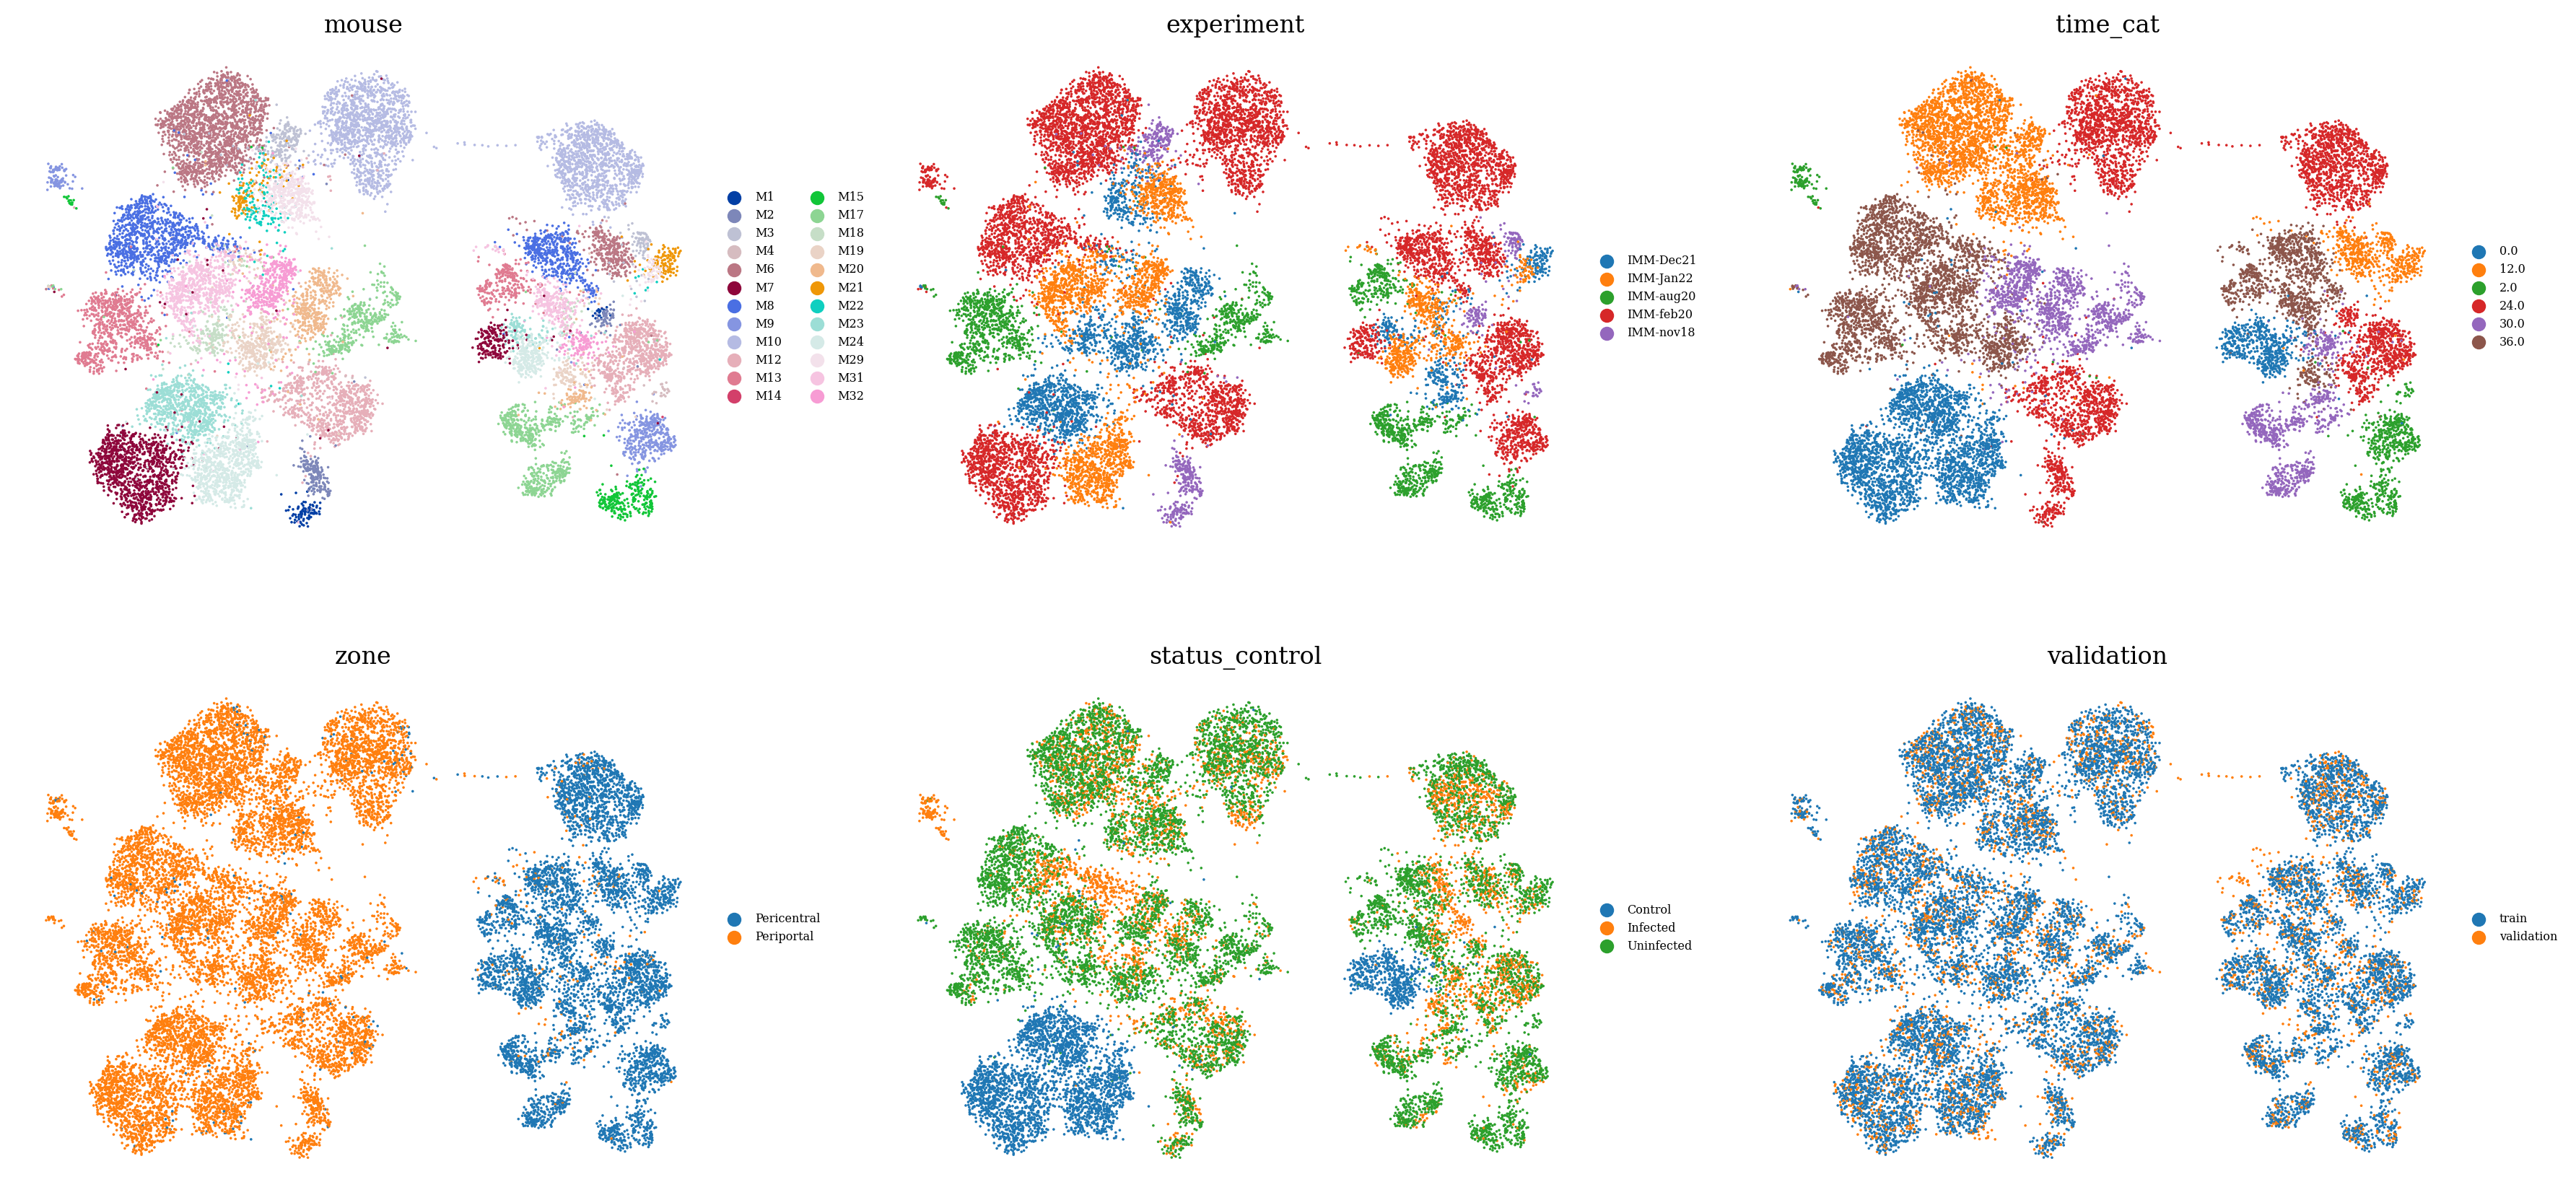

In [15]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [16]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [17]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


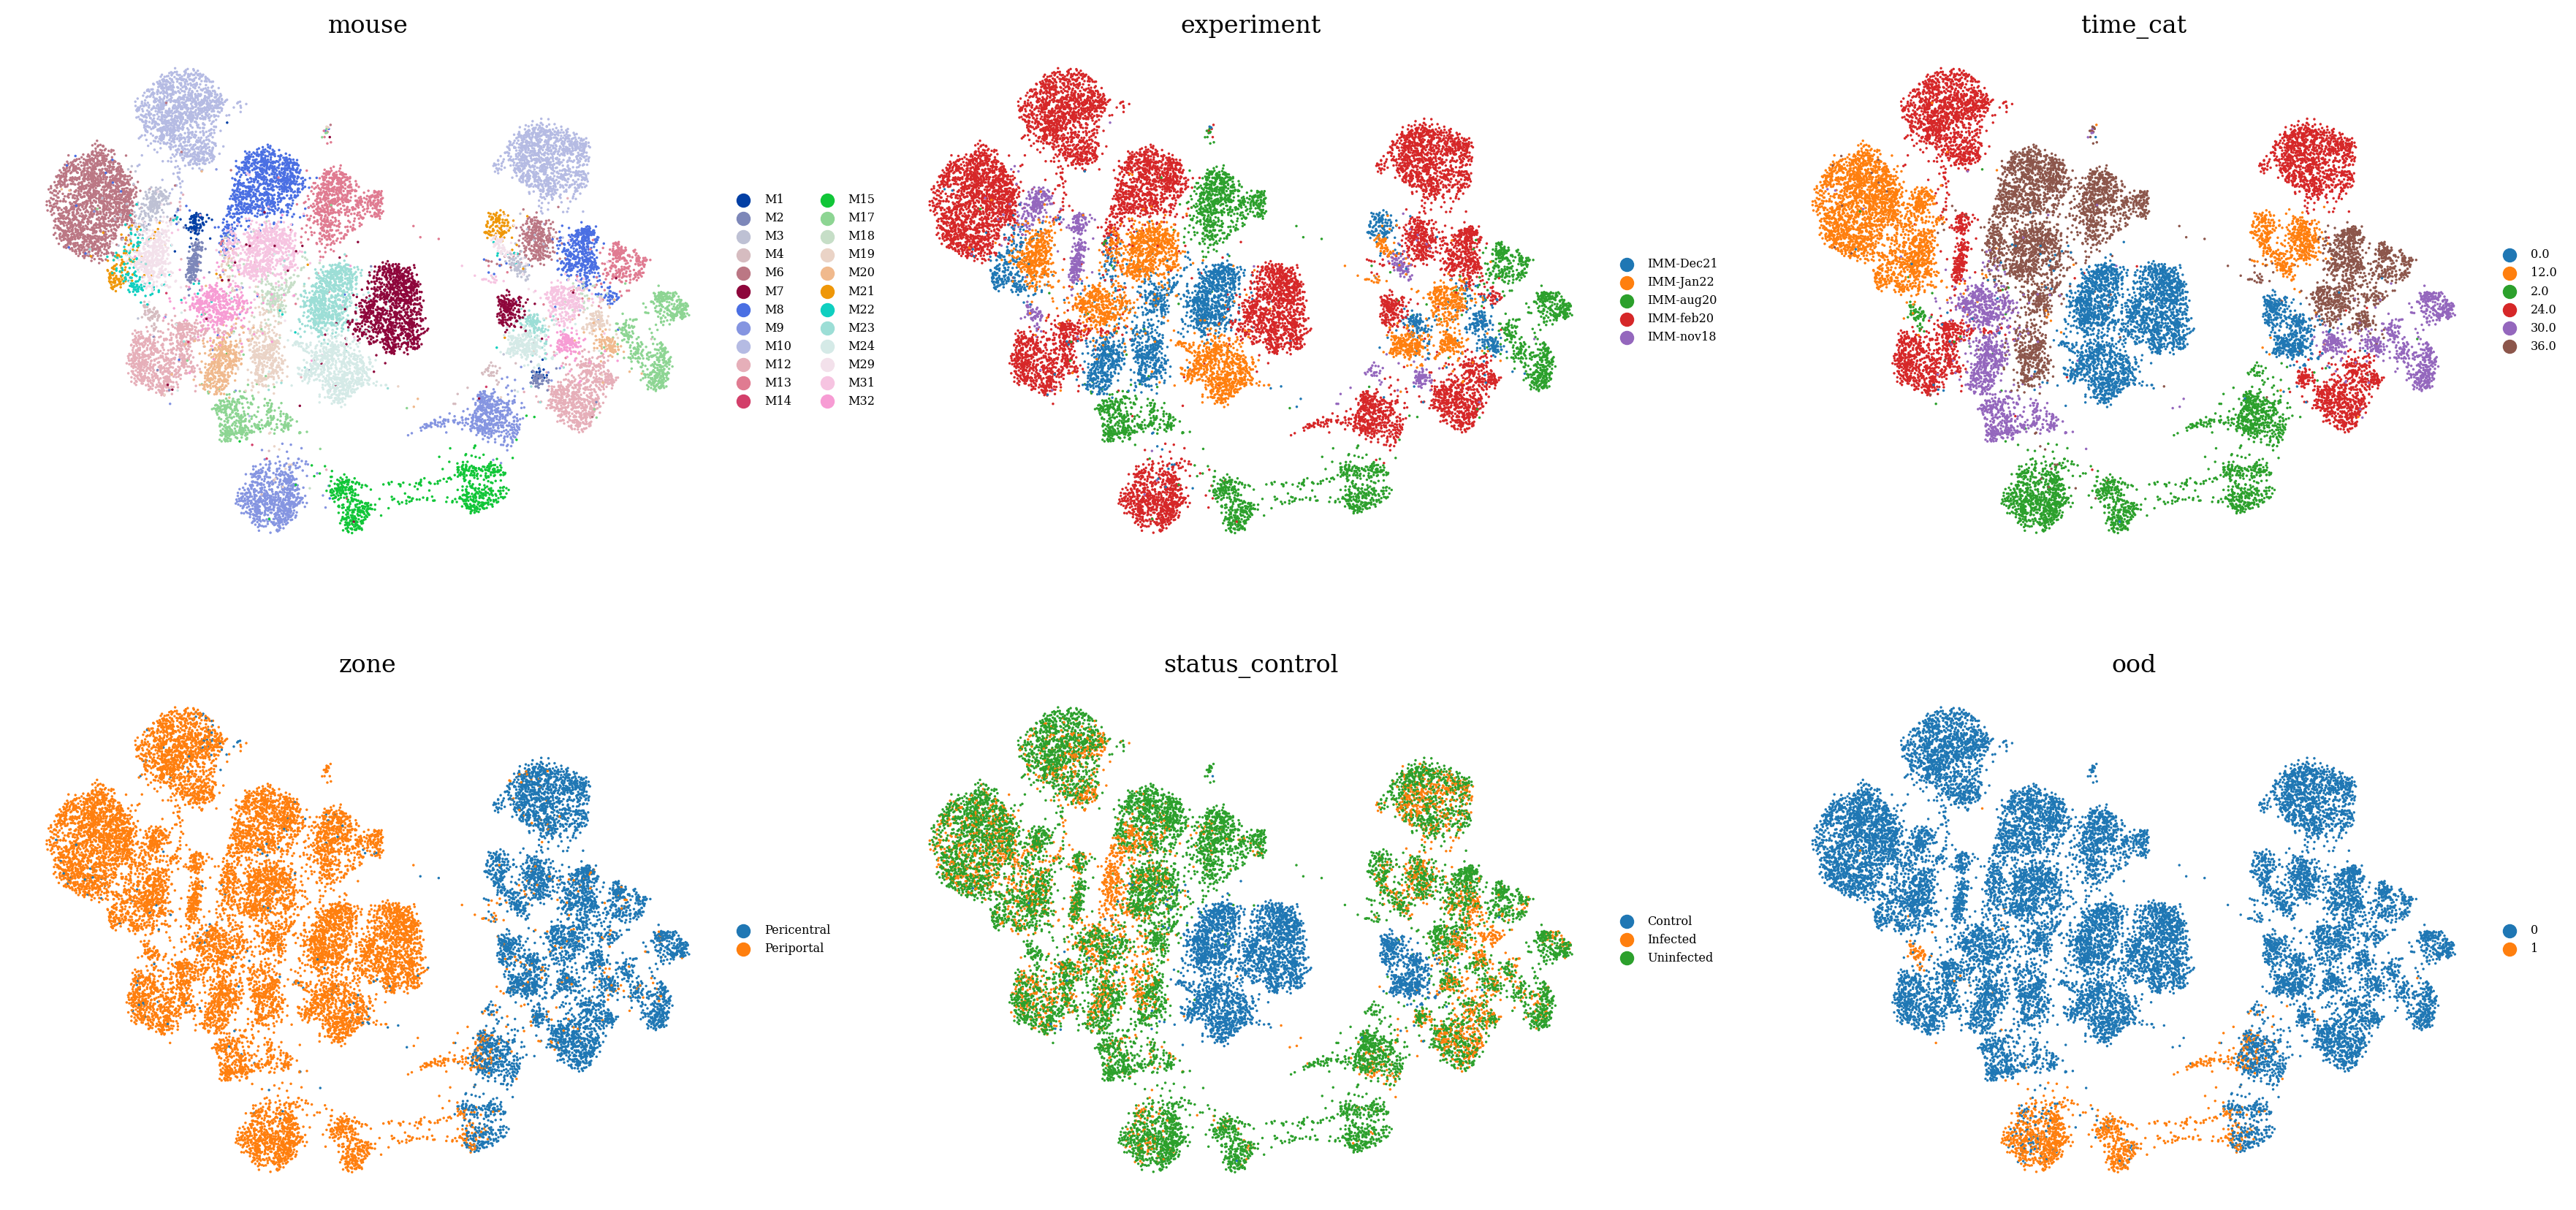

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [19]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.7069227943106072
F1 Weighted: 0.5855447461146036

Baseline Accuracy: 0.5899858290033065


F1 Weighted: 0.5905605349617641



{'accuracy': 0.8601503759398497,
 'precision_macro': 0.5,
 'recall_macro': 0.43007518796992483,
 'f1_score_macro': 0.4624090541632983,
 'precision_micro': 0.8601503759398497,
 'recall_micro': 0.8601503759398497,
 'f1_score_micro': 0.8601503759398497,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8601503759398497,
 'f1_score_weighted': 0.9248181083265966,
 'confusion_matrix': array([[   0,    0],
        [ 186, 1144]])}

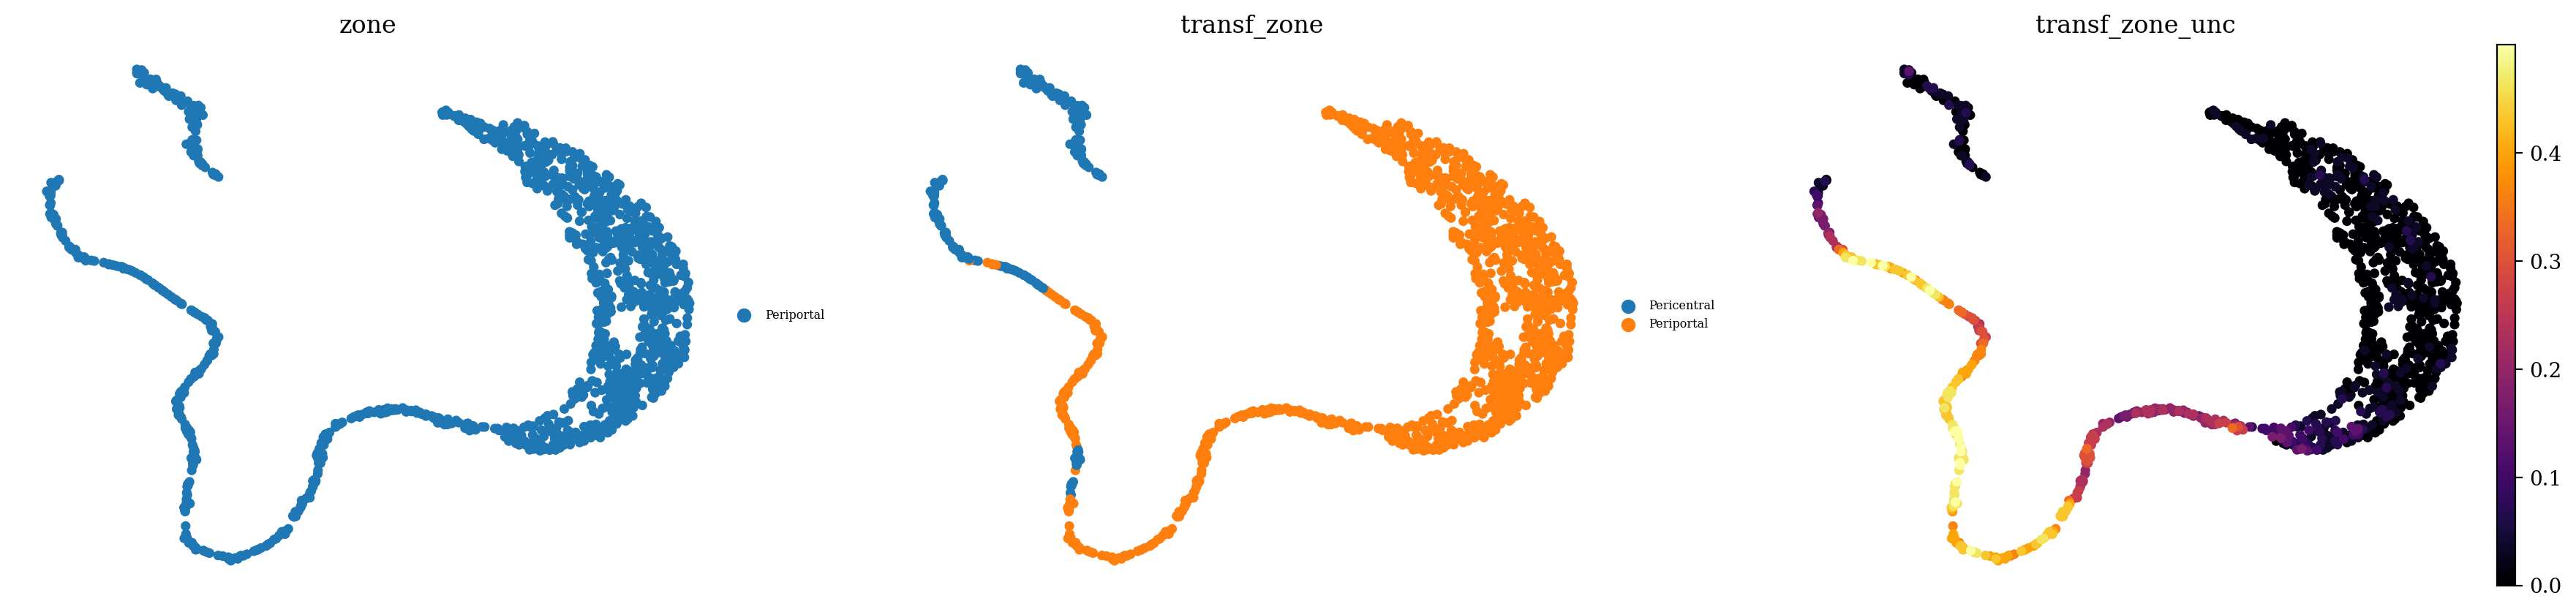

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )